In [1]:
import pandas as pd
import numpy as np
import simpy
import random
import argparse
import torch

In [4]:
import math

# 模拟 C++ 中的 kinfo2t 结构体，这里使用字典来存储结果
# 或者可以使用 collections.namedtuple 或 dataclass
# from collections import namedtuple
# kinfo2t = namedtuple("kinfo2t", ["k1", "k2", "b"])

def returnlinetime3(lambda1: float, w1: float) -> dict:
    """
    Calculates coefficients (partial derivatives) and the Z-intercept
    of the tangent plane to the function g(w1, lambda1) = w1 / (lambda1 - w1)
    at the point (w1, lambda1).

    Args:
        lambda1: The value corresponding to the second variable (lambda).
                 In the original C++ code, this is the first function parameter.
                 Corresponds to 'y' in f(x,y) = x/(y-x).
        w1: The value corresponding to the first variable (w).
            In the original C++ code, this is the second function parameter.
            Corresponds to 'x' in f(x,y) = x/(y-x).

    Returns:
        A dictionary representing kinfo2t with the following keys:
        - 'k1': The partial derivative of g with respect to w1 (coefficient for w1).
                Corresponds to ∂f/∂x in f(x,y).
        - 'k2': The partial derivative of g with respect to lambda1 (coefficient for lambda1).
                Corresponds to ∂f/∂y in f(x,y).
        - 'b': The Z-intercept of the tangent plane Z = k1*w1 + k2*lambda1 + b
               at the point (w1, lambda1, g(w1, lambda1)).

    Raises:
        ValueError: If lambda1 is equal to w1, which would result in division by zero.
    """
    # === 潜在问题：C++ 代码中未检查除以零 ===
    # 在 Python 中，除以零会引发 ZeroDivisionError。
    # 建议在计算前进行检查：
    if lambda1 == w1:
        # 可以选择返回特定的错误标记，或者更符合 Python 习惯的方式是引发异常
        raise ValueError("Division by zero: lambda1 cannot be equal to w1")

    # === 按照 C++ 代码的逻辑进行计算 ===

    # 计算分母的平方
    diff = lambda1 - w1
    denominator_sq = diff ** 2 # 或者使用 math.pow(diff, 2)

    # 计算偏导数
    # C++ code's 'derivative' is actually ∂g/∂w1 (partial with respect to the first variable, w1)
    derivative_w1 = lambda1 / denominator_sq

    # C++ code's 'derivative2' is actually ∂g/∂lambda1 (partial with respect to the second variable, lambda1)
    derivative_lambda1 = -w1 / denominator_sq

    # 对应 C++ 代码中的 result.k1 和 result.k2
    result_k1 = derivative_w1
    result_k2 = derivative_lambda1

    # 计算函数值 g(w1, lambda1)，对应 C++ 代码中的 p1
    function_value = w1 / diff

    # 计算常数项 b (切平面的 Z 截距)
    # 根据切平面方程 Z = k1 * w1 + k2 * lambda1 + b，在点 (w1, lambda1, function_value) 处有：
    # function_value = k1 * w1 + k2 * lambda1 + b
    # 所以 b = function_value - k1 * w1 - k2 * lambda1
    # 对应 C++ 代码中的 re1 = p1 - derivative * w1 - derivative2 * lambda1
    intercept_z = function_value - result_k1 * w1 - result_k2 * lambda1

    # 将结果存储在字典中（模拟 kinfo2t 结构体）
    result = {
        'k1': result_k1,
        'k2': result_k2,
        'b': intercept_z
    }

    return result

# === 示例用法 ===
# 使用之前讨论的点 (w1=952.2, lambda1=953.041) 来测试
point_w1 = 952.2
point_lambda1 = 953.041

try:
    # 注意函数参数顺序：C++ 是 (lambda1, w1)，所以 Python 也保持 (lambda1, w1)
    tangent_info = returnlinetime3(point_lambda1, point_w1)

    print(f"Tangent plane info at (w1={point_w1}, lambda1={point_lambda1}):")
    print(f"  k1 (∂g/∂w1): {tangent_info['k1']}")
    print(f"  k2 (∂g/∂lambda1): {tangent_info['k2']}")
    print(f"  b (Z-intercept): {tangent_info['b']}")

except ValueError as e:
    print(f"Error: {e}")



Tangent plane info at (w1=952.2, lambda1=953.041):
  k1 (∂g/∂w1): 1347.4715141506438
  k2 (∂g/∂lambda1): -1346.282453508551
  b (Z-intercept): 1132.2235434006434


C:\Users\19513\AppData\Local\Temp\ipykernel_15096\4278564751.py:98: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
C:\Users\19513\AppData\Local\Temp\ipykernel_15096\4278564751.py:153: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],


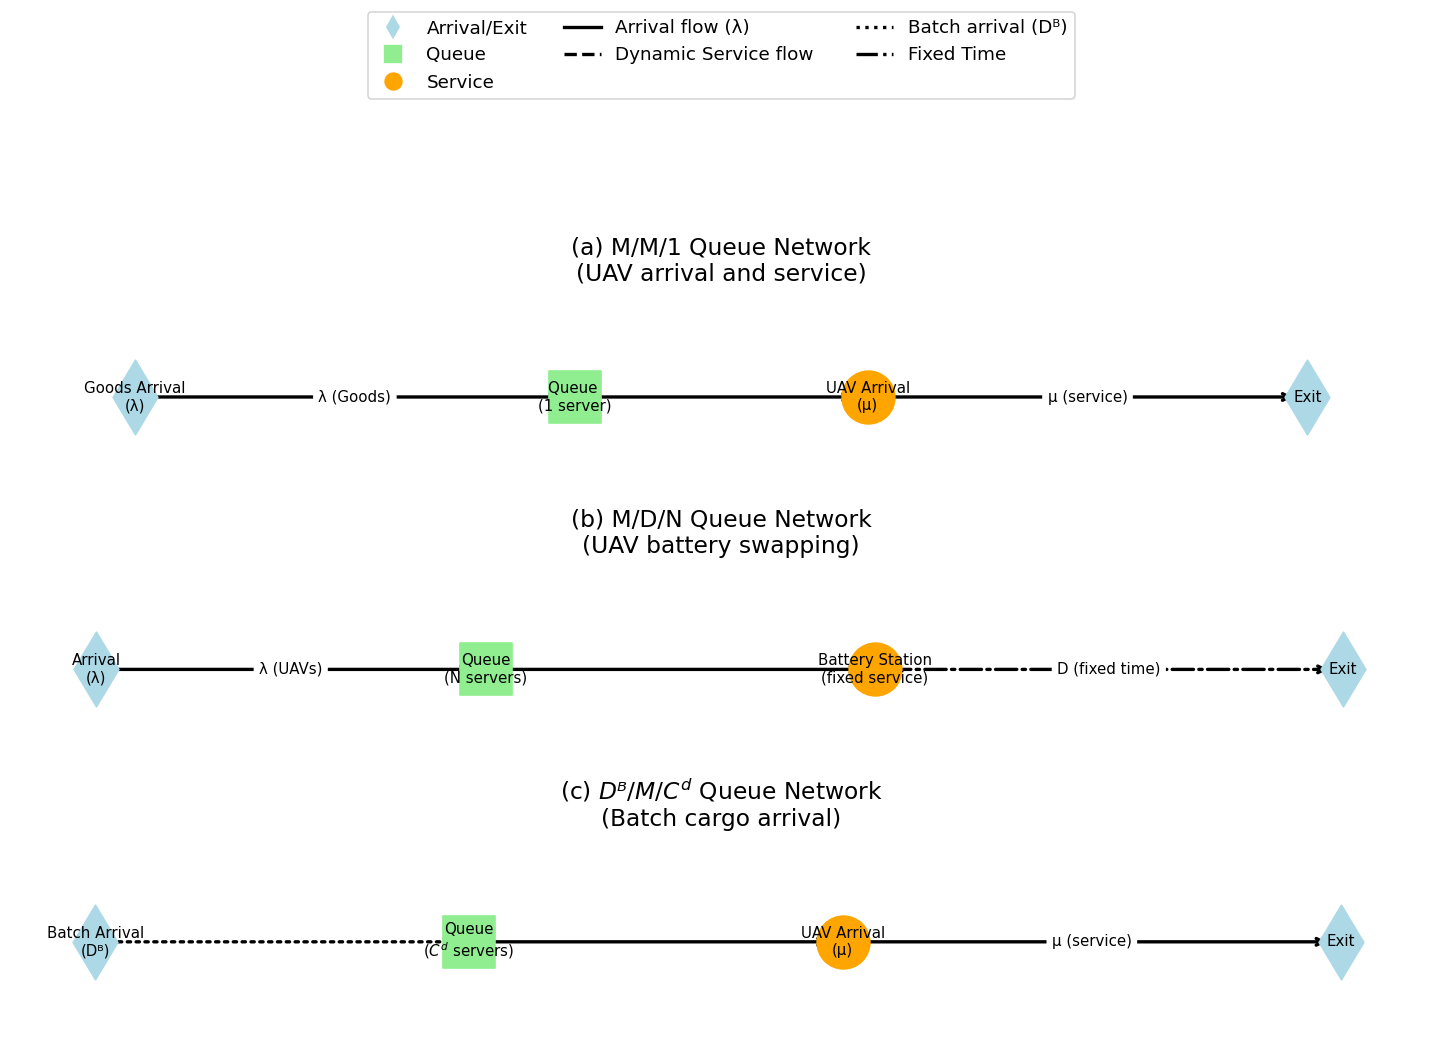

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 设置全局绘图参数
plt.rcParams['font.size'] = 6  # 增大基础字体大小
plt.rcParams['figure.dpi'] = 120

def draw_mm1_network(ax):
    """绘制M/M/1排队网络"""
    G = nx.DiGraph()
    
    # 添加节点
    G.add_node('Arrival', type='source', shape='d')
    G.add_node('Queue', type='queue', shape='s')
    G.add_node('Service', type='service', shape='o')
    G.add_node('Exit', type='exit', shape='d')
    
    # 添加边
    G.add_edge('Arrival', 'Queue', type='arrival', label='λ (Goods)')
    G.add_edge('Queue', 'Service', type='transfer')
    G.add_edge('Service', 'Exit', type='service', label='μ (service)')
    
    # 自定义布局
    pos = {
        'Arrival': (0, 0),
        'Queue': (1.5, 0),
        'Service': (2.5, 0),
        'Exit': (4, 0)
    }
    
    # 绘制节点
    for node_type, shape, color in [('source', 'd', 'lightblue'),
                                   ('queue', 's', 'lightgreen'),
                                   ('service', 'o', 'orange'),
                                   ('exit', 'd', 'lightblue')]:
        nodes = [n for n, d in G.nodes(data=True) if d['type'] == node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_shape=shape, 
                             node_color=color, node_size=1000, ax=ax)
    


    # 绘制边
    nx.draw_networkx_edges(G, pos, edgelist=[('Arrival', 'Queue'), ('Queue', 'Service'), ('Service', 'Exit')],
                          arrows=True, arrowstyle='->', width=2, ax=ax)
    
    # 绘制边标签
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, ax=ax)
    
    # 绘制节点标签
    node_labels = {
        'Arrival': 'Goods Arrival\n(λ)',
        'Queue': 'Queue \n(1 server)',
        'Service': 'UAV Arrival\n(μ)',
        'Exit': 'Exit'
    }
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9, ax=ax)
    
    ax.set_title('(a) M/M/1 Queue Network\n(UAV arrival and service)', fontsize=14)
    ax.axis('off')

def draw_mdn_network(ax):
    """绘制M/D/N排队网络"""
    G = nx.DiGraph()
    
    # 添加节点
    G.add_node('Arrival', type='source', shape='d')
    G.add_node('Queue', type='queue', shape='s')
    G.add_node('Battery Station', type='service', shape='o')
    G.add_node('Exit', type='exit', shape='d')
    
    # 添加边
    G.add_edge('Arrival', 'Queue', type='arrival', label='λ (UAVs)',style='-')
    G.add_edge('Queue', 'Battery Station', type='transfer',style='-')
    G.add_edge('Battery Station', 'Exit', type='service',style = "-.",  label='D (fixed time)')
    
    # 自定义布局
    pos = {
        'Arrival': (0, 0),
        'Queue': (1.5, 0),
        'Battery Station': (3, 0),
        'Exit': (4.8, 0)
    }
    
    # 绘制节点
    for node_type, shape, color in [('source', 'd', 'lightblue'),
                                   ('queue', 's', 'lightgreen'),
                                   ('service', 'o', 'orange'),
                                   ('exit', 'd', 'lightblue')]:
        nodes = [n for n, d in G.nodes(data=True) if d['type'] == node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_shape=shape, 
                             node_color=color, node_size=1000, ax=ax)
    
    # 绘制边
    for edge in G.edges(data=True):
        u, v, d = edge
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], 
                              arrows=True, arrowstyle='->', 
                              width=2, style=d['style'], ax=ax)
    
    # 绘制边标签
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, ax=ax)
    
    # 绘制节点标签
    node_labels = {
        'Arrival': 'Arrival\n(λ)',
        'Queue': 'Queue\n(N servers)',
        'Battery Station': 'Battery Station\n(fixed service)',
        'Exit': 'Exit'
    }
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9, ax=ax)
    
    ax.set_title('(b) M/D/N Queue Network\n(UAV battery swapping)', fontsize=14)
    ax.axis('off')

def draw_dbm1_network(ax):
    """绘制Dᴮ/M/1排队网络"""
    G = nx.DiGraph()
    
    # 添加节点
    G.add_node('Arrival', type='source', shape='d')
    G.add_node('Queue', type='queue', shape='s')
    G.add_node('UAV Service', type='service', shape='o')
    G.add_node('Exit', type='exit', shape='d')
    
    # 添加边并指定线型
    G.add_edge('Arrival', 'Queue', type='arrival', style=':', )
    G.add_edge('Queue', 'UAV Service', type='transfer', style='-')
    G.add_edge('UAV Service', 'Exit', type='service', style='-', label='μ (service)')
    
    # 自定义布局
    pos = {
        'Arrival': (0, 0),
        'Queue': (1.5, 0),
        'UAV Service': (3, 0),
        'Exit': (5, 0)
    }
    
    # 绘制节点
    for node_type, shape, color in [('source', 'd', 'lightblue'),
                                   ('queue', 's', 'lightgreen'),
                                   ('service', 'o', 'orange'),
                                   ('exit', 'd', 'lightblue')]:
        nodes = [n for n, d in G.nodes(data=True) if d['type'] == node_type]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_shape=shape, 
                             node_color=color, node_size=1000, ax=ax)
    
    # 分别绘制不同类型的边以应用不同样式
    for edge in G.edges(data=True):
        u, v, d = edge
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], 
                              arrows=True, arrowstyle='->', 
                              width=2, style=d['style'], ax=ax)
    
    # 绘制边标签
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, ax=ax)
    
    # 绘制节点标签
    node_labels = {
        'Arrival': 'Batch Arrival\n(Dᴮ)',
        'Queue': 'Queue\n($C^{d}$ servers)',
        'UAV Service': 'UAV Arrival\n(μ)',
        'Exit': 'Exit'
    }
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9, ax=ax)
    
    ax.set_title('(c) $Dᴮ/M/C^{d}$ Queue Network\n(Batch cargo arrival)', fontsize=14)
    ax.axis('off')




# 创建三幅子图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

# 绘制三个排队网络
draw_mm1_network(ax1)
draw_mdn_network(ax2)
draw_dbm1_network(ax3)

# 创建统一的图例
legend_elements = [
    plt.Line2D([0], [0], marker='d', color='w', label='Arrival/Exit', markerfacecolor='lightblue', markersize=12),
    plt.Line2D([0], [0], marker='s', color='w', label='Queue', markerfacecolor='lightgreen', markersize=12),
    plt.Line2D([0], [0], marker='o', color='w', label='Service', markerfacecolor='orange', markersize=12),
    plt.Line2D([0], [0], color='black', lw=2, label='Arrival flow (λ)'),
    plt.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Dynamic Service flow '),
    plt.Line2D([0], [0], color='black', lw=2, linestyle=':', label='Batch arrival (Dᴮ)'),
    plt.Line2D([0], [0], color='black', lw=2, linestyle='-.', label='Fixed Time')
]

# 添加图例在图形上方
fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=11)

# 调整布局
plt.tight_layout()
plt.subplots_adjust(top=0.8)  # 为图例留出空间
plt.show()

In [6]:
class uav:
    def __init__(self, env, name):
        self.env = env
        self.waitingtime = 0
        self.starttime = 0
        self.ifserve = False

    def updatewaitingtime(self,env):
        while True:
            if self.ifserve == True:
                self.waitingtime = env.now - self.starttime


class goods:
    def __init__(self, env, name):
        self.env = env
        self.waitingtime = 0
        self.starttime = 0
        self.ifserve = False
        self.name = name
    def updatewaitingtime(self,env):
        while True:
            if self.ifserve == True:
                self.waitingtime = env.now - self.starttime

In [7]:
np.random.exponential(scale=50)

93.95720106978771

In [8]:
import simpy
import numpy as np

global_uav_num = 0
global_goods_num = 0
global_uav_waitingtime = 0
global_goods_waitingtime = 0

class UAV:
    def __init__(self, env, name,starttime):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class Goods:
    def __init__(self, env, name,starttime=0):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def enter_queue(self, env):
        self.starttime = env.now

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class DBMDistributionStation:
    def __init__(self, env, goodsarrivetime, goodsexp, uavexp):
        self.env = env
        self.goodsarrivetime = goodsarrivetime
        self.goodsexp = goodsexp
        self.uavexp = uavexp
        self.uavqueue = simpy.Store(env) # Changed to simpy.Store
        self.goodsqueue = simpy.Store(env)
        self.uav_list = [] # To track individual UAVs if needed

        self.goods_count = 0
        env.process(self.goods_arrival_process())
        env.process(self.uav_arrival_process())
        env.process(self.serving_process())

    def goods_arrival_process(self):
        while True:
            yield self.env.timeout(self.goodsarrivetime)
            num_goods = max(1, int(np.random.exponential(scale=self.goodsexp))) # Ensure at least one good arrives
            print(f"Goods batch of size {num_goods} arrives at {self.env.now}")
            for i in range(num_goods):
                goods1 = Goods(self.env, f"goods {self.goods_count}",starttime=self.env.now)
                goods1.enter_queue(self.env)
                yield self.goodsqueue.put(goods1) # Yield when putting into the store
                self.goods_count += 1
                print(f"Goods {goods1.name} arrive at {self.env.now}")

    def uav_arrival_process(self):
        uav_id = 0
        while True:
            yield self.env.timeout(np.random.exponential(scale=self.uavexp))
            uav1 = UAV(self.env, f"uav {uav_id}",starttime=self.env.now)
            self.uav_list.append(uav1)
            yield self.uavqueue.put(uav1) # Yield when putting into the store
            print(f"UAV {uav1.name} arrives at {self.env.now}")
            uav_id += 1

    def serving_process(self):
        global global_uav_num
        global global_goods_num
        global global_uav_waitingtime
        global global_goods_waitingtime

        while True:
            # Wait for a good and a UAV to be available
            goods_to_serve = yield self.goodsqueue.get()
            uav_available = yield self.uavqueue.get() # Get a UAV from the store

            # Start service
            goods_to_serve.start_service(self.env)
            uav_available.start_service(self.env)

            goods_to_serve.waitingtime = self.env.now - goods_to_serve.starttime
            uav_available.waitingtime = self.env.now - uav_available.starttime

            global_goods_waitingtime += goods_to_serve.waitingtime
            global_uav_waitingtime += uav_available.waitingtime

            print(f"UAV {uav_available.name} starts serving {goods_to_serve.name} at {self.env.now}")


            # End service
            goods_to_serve.end_service(self.env)
            uav_available.end_service(self.env)

            global_goods_num += 1
            global_uav_num += 1
            print(f"UAV {uav_available.name} finishes serving {goods_to_serve.name} at {self.env.now}, Goods waiting time: {goods_to_serve.waitingtime:.2f}, UAV waiting time: {uav_available.waitingtime:.2f}")

env = simpy.Environment()
goodsarrivetime_mean = 0.5  # Average time between batch arrivals
goodsexp_mean = 50        # Average number of goods per batch
uavexp_mean = 1/100          # Average time between UAV arrivals (inverse of arrival rate)
service_time_mean = 2     # Average service time per good


In [9]:
import simpy
import numpy as np

global_uav_num = 0
global_goods_num = 0
global_uav_waitingtime = 0
global_goods_waitingtime = 0

class UAV:
    def __init__(self, env, name,starttime):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class Goods:
    def __init__(self, env, name,starttime=0):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def enter_queue(self, env):
        self.starttime = env.now

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class DM1DistributionStation:
    def __init__(self, env, goodsarrivetime,uavexp, service_time_mean):
        self.env = env
        self.goodsarrivetime = goodsarrivetime
        self.uavexp = uavexp
        self.service_time_mean = service_time_mean
        self.uavqueue = simpy.Store(env) # Changed to simpy.Store
        self.goodsqueue = simpy.Store(env)
        self.uav_list = [] # To track individual UAVs if needed

        self.goods_count = 0
        env.process(self.goods_arrival_process())
        env.process(self.uav_arrival_process())
        env.process(self.serving_process())

    def goods_arrival_process(self):
        while True:
            yield self.env.timeout(np.random.exponential(scale=self.goodsarrivetime))
            num_goods = 1
            print(f"Goods batch of size {num_goods} arrives at {self.env.now}")
            for i in range(num_goods):
                goods1 = Goods(self.env, f"goods {self.goods_count}",starttime=self.env.now)
                goods1.enter_queue(self.env)
                yield self.goodsqueue.put(goods1) # Yield when putting into the store
                self.goods_count += 1
                print(f"Goods {goods1.name} arrive at {self.env.now}")

    def uav_arrival_process(self):
        uav_id = 0
        while True:
            yield self.env.timeout(np.random.exponential(scale=self.uavexp))
            uav1 = UAV(self.env, f"uav {uav_id}",starttime=self.env.now)
            self.uav_list.append(uav1)
            yield self.uavqueue.put(uav1) # Yield when putting into the store
            print(f"UAV {uav1.name} arrives at {self.env.now}")
            uav_id += 1

    def serving_process(self):
        global global_uav_num
        global global_goods_num
        global global_uav_waitingtime
        global global_goods_waitingtime

        while True:
            # Wait for a good and a UAV to be available
            goods_to_serve = yield self.goodsqueue.get()
            uav_available = yield self.uavqueue.get() # Get a UAV from the store

            # Start service
            goods_to_serve.start_service(self.env)
            uav_available.start_service(self.env)

            goods_to_serve.waitingtime = self.env.now - goods_to_serve.starttime
            uav_available.waitingtime = self.env.now - uav_available.starttime

            global_goods_waitingtime += goods_to_serve.waitingtime
            global_uav_waitingtime += uav_available.waitingtime

            print(f"UAV {uav_available.name} starts serving {goods_to_serve.name} at {self.env.now}")
            # yield self.env.timeout(np.random.exponential(scale=self.service_time_mean)) # S   ervice time

            # End service
            goods_to_serve.end_service(self.env)
            uav_available.end_service(self.env)

            global_goods_num += 1
            global_uav_num += 1
            print(f"UAV {uav_available.name} finishes serving {goods_to_serve.name} at {self.env.now}, Goods waiting time: {goods_to_serve.waitingtime:.2f}, UAV waiting time: {uav_available.waitingtime:.2f}")

env = simpy.Environment()
goodsarrivetime_mean = 0.5  # Average time between batch arrivals
uavexp_mean = 1/10          # Average time between UAV arrivals (inverse of arrival rate)
service_time_mean = 2     # Average service time per good

station = DM1DistributionStation(env, goodsarrivetime_mean, uavexp_mean, service_time_mean)

simulation_duration = 20
env.run(until=simulation_duration)

print("\nSimulation Results:")
if global_goods_num > 0:
    print(f"Average Goods Waiting Time: {global_goods_waitingtime / global_goods_num:.2f}")
else:
    print("No goods were served.")

if global_uav_num > 0:
    print(f"Average UAV Waiting Time: {global_uav_waitingtime / global_uav_num:.2f}")
else:
    print("No UAVs performed service.")

UAV uav 0 arrives at 0.126066981909408
Goods batch of size 1 arrives at 0.150731500340595
Goods goods 0 arrive at 0.150731500340595
UAV uav 0 starts serving goods 0 at 0.150731500340595
UAV uav 0 finishes serving goods 0 at 0.150731500340595, Goods waiting time: 0.00, UAV waiting time: 0.02
Goods batch of size 1 arrives at 0.20552507593964917
Goods goods 1 arrive at 0.20552507593964917
UAV uav 1 arrives at 0.4975475685696773
UAV uav 1 starts serving goods 1 at 0.4975475685696773
UAV uav 1 finishes serving goods 1 at 0.4975475685696773, Goods waiting time: 0.29, UAV waiting time: 0.00
UAV uav 2 arrives at 0.5294015012326654
UAV uav 3 arrives at 0.5941156062574562
UAV uav 4 arrives at 0.6702611628888818
Goods batch of size 1 arrives at 0.8273196062620555
Goods goods 2 arrive at 0.8273196062620555
UAV uav 2 starts serving goods 2 at 0.8273196062620555
UAV uav 2 finishes serving goods 2 at 0.8273196062620555, Goods waiting time: 0.00, UAV waiting time: 0.30
UAV uav 5 arrives at 0.835314388

In [10]:
import simpy
import numpy as np

global_uav_num = 0
global_goods_num = 0
global_uav_waitingtime = 0
global_goods_waitingtime = 0

class UAV:
    def __init__(self, env, name,starttime):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class Goods:
    def __init__(self, env, name,starttime=0):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def enter_queue(self, env):
        self.starttime = env.now

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class MM1DistributionStation:
    def __init__(self, env, goodsarrivetime, service_time_mean):
        self.env = env
        self.goodsarrivetime = goodsarrivetime
        self.service_time_mean = service_time_mean
        self.uavqueue = simpy.Store(env) # Changed to simpy.Store
        self.goodsqueue = simpy.Store(env)
        self.uav_list = [] # To track individual UAVs if needed

        self.goods_count = 0
        env.process(self.goods_arrival_process())
        env.process(self.serving_process())

    def goods_arrival_process(self):
        while True:
            yield self.env.timeout(np.random.exponential(scale=self.goodsarrivetime))
            num_goods = 1
            print(f"Goods batch of size {num_goods} arrives at {self.env.now}")
            for i in range(num_goods):
                goods1 = Goods(self.env, f"goods {self.goods_count}",starttime=self.env.now)
                goods1.enter_queue(self.env)
                yield self.goodsqueue.put(goods1) # Yield when putting into the store
                self.goods_count += 1
                print(f"Goods {goods1.name} arrive at {self.env.now}")

    def serving_process(self):
        global global_uav_num
        global global_goods_num
        global global_uav_waitingtime
        global global_goods_waitingtime

        while True:
            # Wait for a good and a UAV to be available
            goods_to_serve = yield self.goodsqueue.get()


            # Start service
            goods_to_serve.start_service(self.env)

            yield self.env.timeout(np.random.exponential(scale=self.service_time_mean)) # S   ervice time

            goods_to_serve.waitingtime = self.env.now - goods_to_serve.starttime
            global_goods_waitingtime += goods_to_serve.waitingtime
            # End service
            goods_to_serve.end_service(self.env)

            global_goods_num += 1

            print(f"Goods waiting time: {goods_to_serve.waitingtime:.2f}")

env = simpy.Environment()
goodsarrivetime_mean = 0.02  # Average time between batch arrivals
service_time_mean = 0.018     # Average service time per good

station = MM1DistributionStation(env, goodsarrivetime_mean, service_time_mean)

simulation_duration =50
env.run(until=simulation_duration)

print("\nSimulation Results:")
if global_goods_num > 0:
    print(f"Average Goods Waiting Time: {global_goods_waitingtime / global_goods_num:.2f}")
else:
    print("No goods were served.")

if global_uav_num > 0:
    print(f"Average UAV Waiting Time: {global_uav_waitingtime / global_uav_num:.2f}")
else:
    print("No UAVs performed service.")

Goods batch of size 1 arrives at 0.0012908383036293752
Goods goods 0 arrive at 0.0012908383036293752
Goods waiting time: 0.00
Goods batch of size 1 arrives at 0.03397842398267542
Goods goods 1 arrive at 0.03397842398267542
Goods batch of size 1 arrives at 0.06127221644047933
Goods goods 2 arrive at 0.06127221644047933
Goods waiting time: 0.03
Goods batch of size 1 arrives at 0.08546573882453753
Goods goods 3 arrive at 0.08546573882453753
Goods batch of size 1 arrives at 0.08821058384072161
Goods goods 4 arrive at 0.08821058384072161
Goods waiting time: 0.03
Goods waiting time: 0.02
Goods batch of size 1 arrives at 0.10497845454813588
Goods goods 5 arrive at 0.10497845454813588
Goods batch of size 1 arrives at 0.11633591168015862
Goods goods 6 arrive at 0.11633591168015862
Goods batch of size 1 arrives at 0.12097747763250008
Goods goods 7 arrive at 0.12097747763250008
Goods waiting time: 0.04
Goods batch of size 1 arrives at 0.19286088324786377
Goods goods 8 arrive at 0.1928608832478637

In [ ]:

env = simpy.Environment()
goodsarrivetime_mean = 0.2  # Average time between batch arrivals
goodsexp_mean = 10        # Average number of goods per batch
uavexp_mean = 0.019         # Average time between UAV arrivals (inverse of arrival rate)
service_time_mean = 2     # Average service time per good
arrivalrate = goodsarrivetime_mean/goodsexp_mean

global_uav_num = 0
global_goods_num = 0
global_uav_waitingtime = 0
global_goods_waitingtime = 0


station = DBMDistributionStation(env, goodsarrivetime_mean, goodsexp_mean, uavexp_mean)

simulation_duration = 50
env.run(until=simulation_duration)

print("\nSimulation Results:")
if global_goods_num > 0:
    print(f"Average Goods Waiting Time: {global_goods_waitingtime / global_goods_num:.2f}")
else:
    print("No goods were served.")

if global_uav_num > 0:
    print(f"Average UAV Waiting Time: {global_uav_waitingtime / global_uav_num:.2f}")
else:
    print("No UAVs performed service.")
print(1/(1/uavexp_mean - 1/arrivalrate)) 

In [ ]:
uavexp_rates = np.linspace(0.008, 0.009, 10)  # 不同的 UAV 到达率
arrivalrates = np.linspace(0.01, 0.02, 10)    # 不同的货物到达率
errors = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差
mm1_wlist = []
db1mlist = []
# 实验循环
for i, uavexp_rate in enumerate(uavexp_rates):
    for j, arrivalrate in enumerate(arrivalrates):
        # 计算理论值和模拟值
        mu = uavexp_rate
        lambda_ = arrivalrate
        mm1_w = 1 / (1/mu - 1/lambda_) 
        mm1_wlist.append(mm1_w)
mm1_wlist

In [5]:
class UAV:
    def __init__(self, env, name,starttime):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class Goods:
    def __init__(self, env, name,starttime=0):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def enter_queue(self, env):
        self.starttime = env.now

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

            
class DBMDistributionStation:
    def __init__(self, env, goodsarrivetime, goodsexp, uavexp):
        self.env = env
        self.goodsarrivetime = goodsarrivetime
        self.goodsexp = goodsexp
        self.uavexp = uavexp
        self.uavqueue = simpy.Store(env) # Changed to simpy.Store
        self.goodsqueue = simpy.Store(env)
        self.uav_list = [] # To track individual UAVs if needed
        self.global_goods_num = 0
        self.global_uav_num = 0
        self.global_goods_waitingtime = 0
        self.goods_count = 0
        env.process(self.goods_arrival_process())
        env.process(self.serving_process())

    def goods_arrival_process(self):
        while True:
            yield self.env.timeout(self.goodsarrivetime)
            num_goods = max(1, int(np.random.exponential(scale=self.goodsexp))) # Ensure at least one good arrives

            for i in range(num_goods):
                goods1 = Goods(self.env, f"goods {self.goods_count}",starttime=self.env.now)
                goods1.enter_queue(self.env)
                yield self.goodsqueue.put(goods1) # Yield when putting into the store
                self.goods_count += 1




    def serving_process(self):


        while True:
            # Wait for a good and a UAV to be available
            goods_to_serve = yield self.goodsqueue.get()


            # Start service
            goods_to_serve.start_service(self.env)

            yield self.env.timeout(np.random.exponential(scale=self.uavexp))
            goods_to_serve.waitingtime = self.env.now - goods_to_serve.starttime


            self.global_goods_waitingtime += goods_to_serve.waitingtime


            # End service
            goods_to_serve.end_service(self.env)


            self.global_goods_num += 1




class DBMDistributionStation2:
    def __init__(self, env, goodsarrivetime, goodsexp, uavexp):
        self.env = env
        self.goodsarrivetime = goodsarrivetime
        self.goodsexp = goodsexp
        self.uavexp = uavexp
        self.uavqueue = simpy.Store(env) # Changed to simpy.Store
        self.goodsqueue = simpy.Store(env)
        self.uav_list = [] # To track individual UAVs if needed
        self.global_goods_num = 0
        self.global_uav_num = 0
        self.global_goods_waitingtime = 0
        self.global_uav_waitingtime = 0
        self.goods_count = 0
        self.uav_count = 0
        env.process(self.goods_arrival_process())
        env.process(self.uav_arrival_process())
        env.process(self.serving_process())

    def goods_arrival_process(self):
        while True:
            yield self.env.timeout(self.goodsarrivetime)
            num_goods = max(1, int(np.random.exponential(scale=self.goodsexp))) # Ensure at least one good arrives

            for i in range(num_goods):
                goods1 = Goods(self.env, f"goods {self.goods_count}",starttime=self.env.now)
                goods1.enter_queue(self.env)
                yield self.goodsqueue.put(goods1) # Yield when putting into the store
                self.goods_count += 1
    

    def uav_arrival_process(self):
        uav_id = 0
        while True:
            yield self.env.timeout(np.random.exponential(scale=self.uavexp))
            uav1 = UAV(self.env, f"uav {uav_id}",starttime=self.env.now)
            self.uav_list.append(uav1)
            yield self.uavqueue.put(uav1) # Yield when putting into the store
            uav_id += 1



    def serving_process(self):


        while True:
            # Wait for a good and a UAV to be available
            goods_to_serve = yield self.goodsqueue.get()
            if self.uavqueue:
                uav_available = yield self.uavqueue.get()

            goods_to_serve.start_service(self.env)

            #yield self.env.timeout(np.random.exponential(scale=self.uavexp))
            goods_to_serve.waitingtime = self.env.now - goods_to_serve.starttime
            uav_available.waitingtime = self.env.now - uav_available.starttime

            self.global_goods_waitingtime += goods_to_serve.waitingtime
            self.global_uav_waitingtime += uav_available.waitingtime

            # End service
            goods_to_serve.end_service(self.env)


            self.global_goods_num += 1
            self.global_uav_num += 1



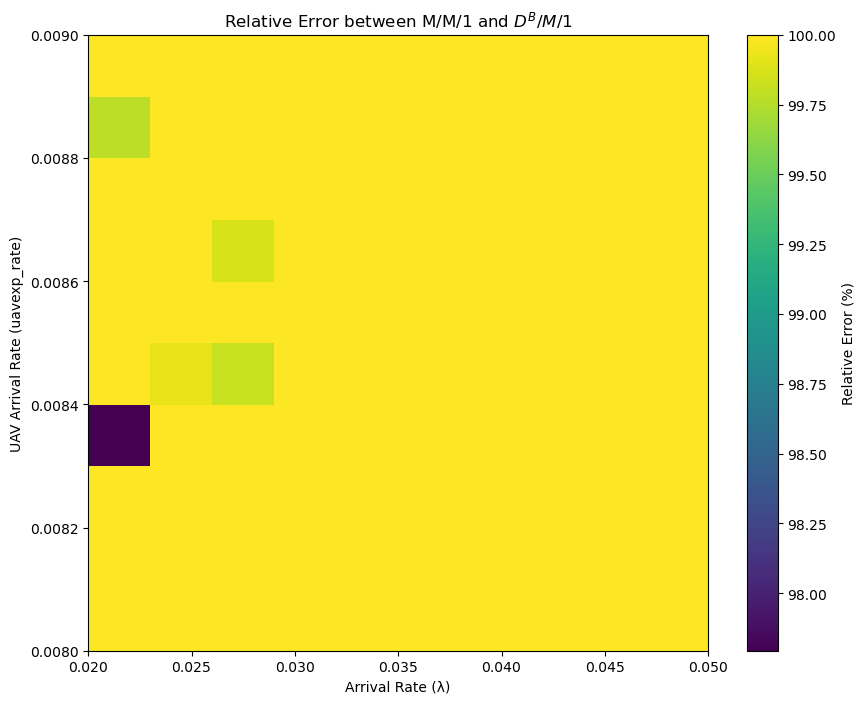

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import simpy
import random
# 定义实验参数
uavexp_rates = np.linspace(0.01, 0.019, 10)  # 不同的 UAV 到达率
arrivalrates = np.linspace(0.02, 0.05, 10)    # 不同的货物到达率
errors = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差
errorsuav = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差
mm1_wlist = []
db1mlist = []
uavwaitinglist = []
ratiolist = []
# 实验循环
for i, uavexp_rate in enumerate(uavexp_rates):
    for j, arrivalrate in enumerate(arrivalrates):
        # 计算理论值和模拟值
        # mu = uavexp_rate
        lambda_ = arrivalrate
        mu = lambda_ * 0.9
        mm1_w = 1 / (1/mu - 1/lambda_)
        ratiolist.append(mu/lambda_) 
        mm1_wlist.append(mm1_w)
        goodsarrivetime_mean = 0.5  
        goodsexp_mean = 1/arrivalrate*goodsarrivetime_mean        # Average number of goods per batch


        env = simpy.Environment()
        station = DBMDistributionStation2(env, goodsarrivetime_mean, goodsexp_mean, uavexp_rate)

        simulation_duration = 24
        env.run(until=simulation_duration)

        dbm1_w = station.global_goods_waitingtime / station.global_goods_num
        db1mlist.append(dbm1_w)

        dm1uav = station.global_uav_waitingtime / station.global_uav_num
        uavwaitinglist.append(dm1uav)
        errors[i, j] = np.abs(mm1_w - dbm1_w) / mm1_w * 100
        errorsuav[i, j] = np.abs(goodsarrivetime_mean/2 - dm1uav) / (goodsarrivetime_mean/2) * 100
# 绘制误差热力图
plt.figure(figsize=(10, 8))
plt.imshow(errors, extent=[arrivalrates[0], arrivalrates[-1], uavexp_rates[0], uavexp_rates[-1]], 
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Relative Error (%)')
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('UAV Arrival Rate (uavexp_rate)')
plt.title('Relative Error between M/M/1 and $D^B/M/1$')
plt.show()

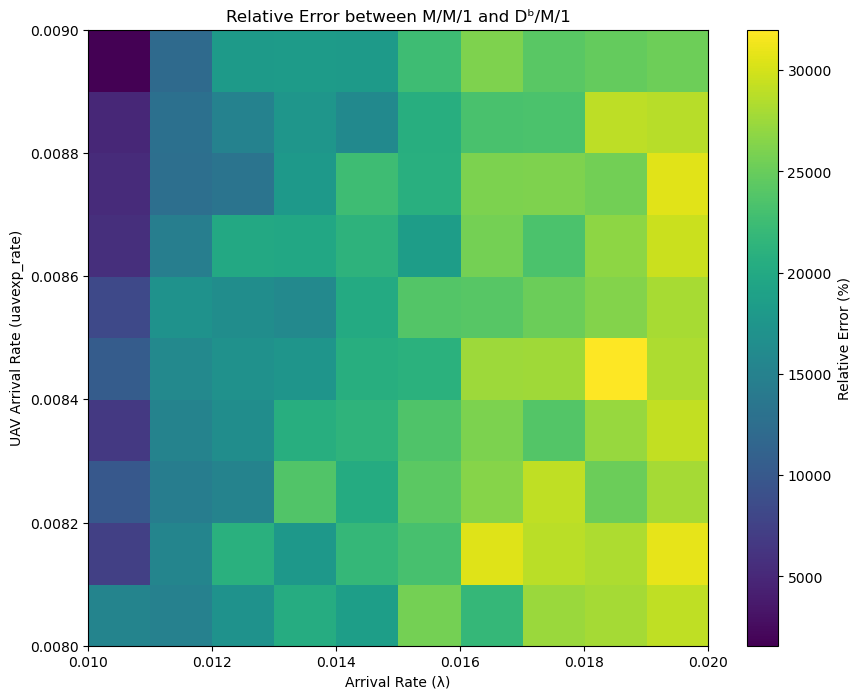

In [69]:
plt.figure(figsize=(10, 8))
plt.imshow(errorsuav, extent=[arrivalrates[0], arrivalrates[-1], uavexp_rates[0], uavexp_rates[-1]], 
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Relative Error (%)')
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('UAV Arrival Rate (uavexp_rate)')
plt.title('Relative Error between M/M/1 and Dᵇ/M/1')
plt.show()

In [18]:
goodsarrivetime_mean = np.linspace(0.3, 1, 8)
goodsarrivetime_mean

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [19]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import simpy
import random
# 定义实验参数
uavexp_rates = np.linspace(0.01, 0.019, 10)  # 不同的 UAV 到达率
arrivalrates = np.linspace(0.001, 0.01, 10)    # 不同的货物到达率
errors = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差
errorsuav = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差

# 实验循环
ratiolist = np.linspace(0.05, 1.1, 50)
goodsarrivetime_meanl = np.linspace(0.2, 1, 9)
for goodsarrivetime_mean in goodsarrivetime_meanl:
    mm1_wlist = []
    db1mlist = []
    uavclist = []
    uavwaitinglist = []
    for arrivalrate in arrivalrates:
        for ratio in ratiolist:
                # mu = uavexp_rate
                lambda_ = arrivalrate
                mu = lambda_ * ratio
                uavclist.append(mu)
                mm1_w = 1 / (1/mu - 1/lambda_)
                uavexp_rate = mu
                mm1_wlist.append(mm1_w)
                goodsarrivetime_mean = goodsarrivetime_mean 
                goodsexp_mean = 1/arrivalrate*goodsarrivetime_mean        # Average number of goods per batch


                env = simpy.Environment()
                station = DBMDistributionStation2(env, goodsarrivetime_mean, goodsexp_mean, uavexp_rate)

                simulation_duration = 24
                env.run(until=simulation_duration)

                dbm1_w = station.global_goods_waitingtime / station.global_goods_num
                db1mlist.append(dbm1_w)

                dm1uav = station.global_uav_waitingtime / station.global_uav_num
                uavwaitinglist.append(dm1uav)
    matrix = np.tile(ratiolist, (10, ))
    arrivalratematrix = np.repeat(arrivalrates, 50)
    uavwaitinglist = np.array(uavwaitinglist)
    db1mlist = np.array(db1mlist)
    uavclist = np.array(uavclist)
    X_combined = np.column_stack((matrix, ))
    uavwaitinglist = uavwaitinglist.reshape(10, 50)
    db1mlist = db1mlist.reshape(10, 50)
    np.savez(f'dbm1_{goodsarrivetime_mean}.npz', X_combined=X_combined, uavwaitinglist=uavwaitinglist, db1mlist=db1mlist, arrivalratematrix=arrivalratematrix, uavclist=uavclist)

In [44]:
class UAV:
    def __init__(self, env, name,starttime):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class Goods:
    def __init__(self, env, name,starttime=0):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def enter_queue(self, env):
        self.starttime = env.now

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

            
class DBMDistributionStation:
    def __init__(self, env, goodsarrivetime, goodsexp, uavexp):
        self.env = env
        self.goodsarrivetime = goodsarrivetime
        self.goodsexp = goodsexp
        self.uavexp = uavexp
        self.uavqueue = simpy.Store(env) # Changed to simpy.Store
        self.goodsqueue = simpy.Store(env)
        self.uav_list = [] # To track individual UAVs if needed
        self.global_goods_num = 0
        self.global_uav_num = 0
        self.global_goods_waitingtime = 0
        self.goods_count = 0
        env.process(self.goods_arrival_process())
        env.process(self.serving_process())

    def goods_arrival_process(self):
        while True:
            yield self.env.timeout(self.goodsarrivetime)
            num_goods = max(1, int(np.random.exponential(scale=self.goodsexp))) # Ensure at least one good arrives

            for i in range(num_goods):
                goods1 = Goods(self.env, f"goods {self.goods_count}",starttime=self.env.now)
                goods1.enter_queue(self.env)
                yield self.goodsqueue.put(goods1) # Yield when putting into the store
                self.goods_count += 1




    def serving_process(self):


        while True:
            # Wait for a good and a UAV to be available
            goods_to_serve = yield self.goodsqueue.get()


            # Start service
            goods_to_serve.start_service(self.env)

            yield self.env.timeout(np.random.exponential(scale=self.uavexp))
            goods_to_serve.waitingtime = self.env.now - goods_to_serve.starttime


            self.global_goods_waitingtime += goods_to_serve.waitingtime


            # End service
            goods_to_serve.end_service(self.env)


            self.global_goods_num += 1




class DBMDistributionStation2:
    def __init__(self, env, goodsarrivetime, goodsexp, uavexp):
        self.env = env
        self.goodsarrivetime = goodsarrivetime
        self.goodsexp = goodsexp
        self.uavexp = uavexp
        self.uavqueue = simpy.Store(env) # Changed to simpy.Store
        self.goodsqueue = simpy.Store(env)
        self.uav_list = [] # To track individual UAVs if needed
        self.global_goods_num = 0
        self.global_uav_num = 0
        self.global_goods_waitingtime = 0
        self.global_uav_waitingtime = 0
        self.goods_count = 0
        self.uav_count = 0
        env.process(self.goods_arrival_process())
        env.process(self.uav_arrival_process())
        env.process(self.serving_process())

    def goods_arrival_process(self):
        while True:
            yield self.env.timeout(self.goodsarrivetime)
            num_goods = max(1, int(np.random.exponential(scale=self.goodsexp))) # Ensure at least one good arrives

            for i in range(num_goods):
                goods1 = Goods(self.env, f"goods {self.goods_count}",starttime=self.env.now)
                goods1.enter_queue(self.env)
                yield self.goodsqueue.put(goods1) # Yield when putting into the store
                self.goods_count += 1
    

    def uav_arrival_process(self):
        uav_id = 0
        while True:
            yield self.env.timeout(np.random.exponential(scale=self.uavexp))
            uav1 = UAV(self.env, f"uav {uav_id}",starttime=self.env.now)
            self.uav_list.append(uav1)
            yield self.uavqueue.put(uav1) # Yield when putting into the store
            uav_id += 1



    def serving_process(self):


        while True:
            # Wait for a good and a UAV to be available
            goods_to_serve = yield self.goodsqueue.get()
            if self.uavqueue:
                uav_available = yield self.uavqueue.get()

            goods_to_serve.start_service(self.env)

            #yield self.env.timeout(np.random.exponential(scale=self.uavexp))
            goods_to_serve.waitingtime = self.env.now - goods_to_serve.starttime
            uav_available.waitingtime = self.env.now - uav_available.starttime

            self.global_goods_waitingtime += goods_to_serve.waitingtime
            self.global_uav_waitingtime += uav_available.waitingtime

            # End service
            goods_to_serve.end_service(self.env)


            self.global_goods_num += 1
            self.global_uav_num += 1



In [47]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import simpy
import random
# 定义实验参数
uavexp_rates = np.linspace(0.01, 0.019, 10)  # 不同的 UAV 到达率
arrivalrates = np.linspace(0.001, 0.01, 10)    # 不同的货物到达率
errors = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差
errorsuav = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差

# 实验循环
ratiolist = np.linspace(0.05, 1.1, 50)
goodsarrivetime_meanl = np.linspace(0.2, 1, 9)
mm1_wlist = []
db1mlist = []
uavclist = []
uavwaitinglist = []
goodsarrivetime_mean = 0.1 
for arrivalrate in arrivalrates:
    for ratio in ratiolist:
        lambda_ = arrivalrate
        mu = lambda_ * ratio
        uavclist.append(mu)
        mm1_w = 1 / (1/mu - 1/lambda_)
        uavexp_rate = mu
        mm1_wlist.append(mm1_w)
        goodsexp_mean = 1/arrivalrate*goodsarrivetime_mean        # Average number of goods per batch


        env = simpy.Environment()
        station = DBMDistributionStation2(env, goodsarrivetime_mean, goodsexp_mean, uavexp_rate)

        simulation_duration = 24
        env.run(until=simulation_duration)

        dbm1_w = station.global_goods_waitingtime / station.global_goods_num
        db1mlist.append(dbm1_w)

        dm1uav = station.global_uav_waitingtime / station.global_uav_num
        uavwaitinglist.append(dm1uav)
        print(f"UAV 到达率: {uavexp_rate}, 货物到达率: {arrivalrate}, 比率: {ratio}, 平均等待时间: {dbm1_w}")
matrix = np.tile(ratiolist, (10, ))
arrivalratematrix = np.repeat(arrivalrates, 50)
uavwaitinglist = np.array(uavwaitinglist)
db1mlist = np.array(db1mlist)
uavclist = np.array(uavclist)
X_combined = np.column_stack((matrix, ))
uavwaitinglist = uavwaitinglist.reshape(10, 50)
db1mlist = db1mlist.reshape(10, 50)
np.savez(f'dbm1_{goodsarrivetime_mean}.npz', X_combined=X_combined, uavwaitinglist=uavwaitinglist, db1mlist=db1mlist, arrivalratematrix=arrivalratematrix, uavclist=uavclist)

UAV 到达率: 5e-05, 货物到达率: 0.001, 比率: 0.05, 平均等待时间: 0.0
UAV 到达率: 7.142857142857142e-05, 货物到达率: 0.001, 比率: 0.07142857142857142, 平均等待时间: 0.0
UAV 到达率: 9.285714285714286e-05, 货物到达率: 0.001, 比率: 0.09285714285714286, 平均等待时间: 0.0
UAV 到达率: 0.00011428571428571428, 货物到达率: 0.001, 比率: 0.11428571428571428, 平均等待时间: 0.0
UAV 到达率: 0.00013571428571428572, 货物到达率: 0.001, 比率: 0.13571428571428573, 平均等待时间: 0.0
UAV 到达率: 0.00015714285714285713, 货物到达率: 0.001, 比率: 0.15714285714285714, 平均等待时间: 0.0
UAV 到达率: 0.00017857142857142854, 货物到达率: 0.001, 比率: 0.17857142857142855, 平均等待时间: 0.0
UAV 到达率: 0.0002, 货物到达率: 0.001, 比率: 0.2, 平均等待时间: 0.0
UAV 到达率: 0.00022142857142857142, 货物到达率: 0.001, 比率: 0.22142857142857142, 平均等待时间: 0.0
UAV 到达率: 0.00024285714285714289, 货物到达率: 0.001, 比率: 0.24285714285714288, 平均等待时间: 0.0
UAV 到达率: 0.0002642857142857143, 货物到达率: 0.001, 比率: 0.2642857142857143, 平均等待时间: 0.0
UAV 到达率: 0.0002857142857142857, 货物到达率: 0.001, 比率: 0.2857142857142857, 平均等待时间: 0.0
UAV 到达率: 0.0003071428571428571, 货物到达率: 0.001, 比率: 0.3071428571

In [49]:
import numpy as np
n1 = np.load('dbm1_0.1.npz')
n1['X_combined'].shape, n1['uavwaitinglist'].shape, n1['db1mlist'].shape, n1['arrivalratematrix'].shape, n1['uavclist'].shape

((500, 1), (10, 50), (10, 50), (500,), (500,))

Processing i = 0.1
  R^2 Score: 0.9684
  Coefficient (X_combined[0]): -11.4504
  Intercept: 12.4148
Processing i = 0.2
  R^2 Score: 0.9413
  Coefficient (X_combined[0]): -11.2952
  Intercept: 12.4209
Processing i = 0.3
  R^2 Score: 0.9132
  Coefficient (X_combined[0]): -10.9147
  Intercept: -1.2110
Processing i = 0.4
  R^2 Score: 0.9060
  Coefficient (X_combined[0]): -11.2992
  Intercept: 12.5647
Processing i = 0.5
  R^2 Score: 0.8671
  Coefficient (X_combined[0]): -10.6781
  Intercept: 11.6487
Processing i = 0.6
  R^2 Score: 0.8571
  Coefficient (X_combined[0]): -10.6894
  Intercept: -9.6324
Processing i = 0.7
  R^2 Score: 0.8216
  Coefficient (X_combined[0]): -10.6870
  Intercept: 11.3771
Processing i = 0.8
  R^2 Score: 0.8382
  Coefficient (X_combined[0]): -10.8515
  Intercept: 12.1980
Processing i = 0.9
  R^2 Score: 0.7797
  Coefficient (X_combined[0]): -10.4561
  Intercept: 11.0189
Processing i = 1.0
  R^2 Score: 0.7739
  Coefficient (X_combined[0]): -10.4726
  Intercept: 11.7334


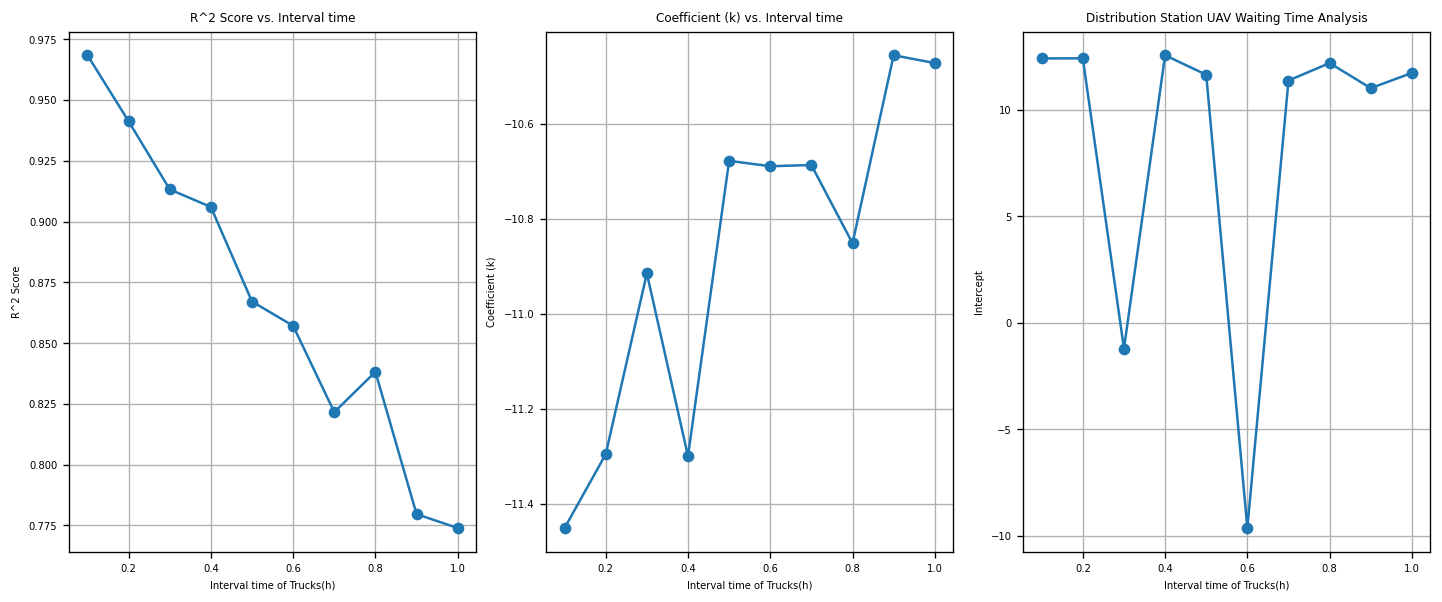

In [56]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt # Import for plotting

r2list = []
klist = []
interceptlist = []

for i in np.linspace(0.1, 1, 10):
    print(f"Processing i = {np.round(i,1)}")
    # Assuming these files exist in your directory
    p1 = np.load(f'dbm1_{np.round(i,1)}.npz') 
    X_combined = p1['X_combined']
    ilits = np.repeat(i, 500).reshape(500, 1)
    X_combined = np.hstack((X_combined, ilits))
    uavwait = p1['uavwaitinglist'].reshape(500, 1)
    degree = 1 

    model_uav = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model_uav.fit(X_combined, uavwait)

    r2 = model_uav.score(X_combined, uavwait)
    linear_regression_model_uav = model_uav.named_steps['linearregression']
    coef = linear_regression_model_uav.coef_[0][1] # Assuming degree 1 and you care about the first feature
    intercept = linear_regression_model_uav.intercept_[0]
    
    print(f"  R^2 Score: {r2:.4f}")
    print(f"  Coefficient (X_combined[0]): {coef:.4f}")
    print(f"  Intercept: {intercept:.4f}")

    r2list.append(r2)
    klist.append(coef)
    interceptlist.append(intercept)

print("\n--- Summary of Results Across i values ---")
print(f"R^2 Scores: {r2list}")
print(f"Coefficients (k): {klist}")
print(f"Intercepts: {interceptlist}")

# Optional: Plotting to visualize trends
i_values = np.linspace(0.1, 1, 10)



plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(i_values, r2list, marker='o')
plt.title('R^2 Score vs. Interval time')
plt.xlabel('Interval time of Trucks(h)')
plt.ylabel('R^2 Score')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(i_values, klist, marker='o')
plt.title('Coefficient (k) vs. Interval time')
plt.xlabel('Interval time of Trucks(h)')
plt.ylabel('Coefficient (k)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(i_values, interceptlist, marker='o')
plt.title('Intercept vs. Interval time')
plt.xlabel('Interval time of Trucks(h)')
plt.ylabel('Intercept')
plt.grid(True)
plt.title('Distribution Station UAV Waiting Time Analysis')
plt.tight_layout()
plt.show()

In [57]:


X_combined_w = np.zeros((500*10, 2))
uavwaitlist = np.zeros((500*10, 1))
waitlist = np.zeros((500*10, 1))






for num,i in enumerate(np.linspace(0.1, 1, 10)):
    print(f"Processing i = {np.round(i,1)}")
    # Assuming these files exist in your directory
    p1 = np.load(f'dbm1_{np.round(i,1)}.npz') 
    X_combined = p1['X_combined']
    ilits = np.repeat(i, 500).reshape(500, 1)
    
    waitl = p1['db1mlist'].reshape(500, 1)
    waitlist[(num*500):(num+1)*500, :] = waitl
    X_combined = np.hstack((X_combined, ilits))
    X_combined_w[(num*500):(num+1)*500, :] = X_combined
    
    uavwait = p1['uavwaitinglist'].reshape(500, 1)
    uavwaitlist[(num*500):(num+1)*500, :] = uavwait
    degree = 1 

    model_uav = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model_uav.fit(X_combined, uavwait)

    r2 = model_uav.score(X_combined, uavwait)
    linear_regression_model_uav = model_uav.named_steps['linearregression']
    coef = linear_regression_model_uav.coef_[0][1] # Assuming degree 1 and you care about the first feature
    intercept = linear_regression_model_uav.intercept_[0]

    print(f"  R^2 Score: {r2:.4f}")
    print(f"  Coefficient (X_combined[0]): {coef:.4f}")
    print(f"  Intercept: {intercept:.4f}")

    
    
    r2list.append(r2)
    klist.append(coef)
    interceptlist.append(intercept)

Processing i = 0.1
  R^2 Score: 0.9684
  Coefficient (X_combined[0]): -11.4504
  Intercept: 12.4148
Processing i = 0.2
  R^2 Score: 0.9413
  Coefficient (X_combined[0]): -11.2952
  Intercept: 12.4209
Processing i = 0.3
  R^2 Score: 0.9132
  Coefficient (X_combined[0]): -10.9147
  Intercept: -1.2110
Processing i = 0.4
  R^2 Score: 0.9060
  Coefficient (X_combined[0]): -11.2992
  Intercept: 12.5647
Processing i = 0.5
  R^2 Score: 0.8671
  Coefficient (X_combined[0]): -10.6781
  Intercept: 11.6487
Processing i = 0.6
  R^2 Score: 0.8571
  Coefficient (X_combined[0]): -10.6894
  Intercept: -9.6324
Processing i = 0.7
  R^2 Score: 0.8216
  Coefficient (X_combined[0]): -10.6870
  Intercept: 11.3771
Processing i = 0.8
  R^2 Score: 0.8382
  Coefficient (X_combined[0]): -10.8515
  Intercept: 12.1980
Processing i = 0.9
  R^2 Score: 0.7797
  Coefficient (X_combined[0]): -10.4561
  Intercept: 11.0189
Processing i = 1.0
  R^2 Score: 0.7739
  Coefficient (X_combined[0]): -10.4726
  Intercept: 11.7334


Processing i = 0.1
Processing i = 0.2
Processing i = 0.3
Processing i = 0.4
Processing i = 0.5
Processing i = 0.6
Processing i = 0.7
Processing i = 0.8
Processing i = 0.9
Processing i = 1.0


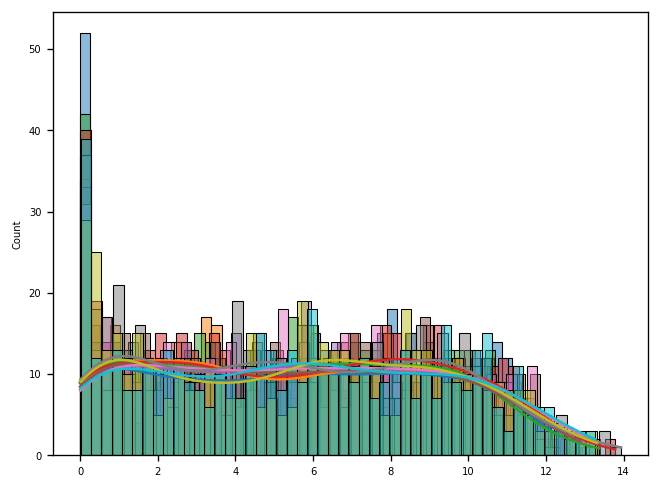

In [60]:
import seaborn as sns
for num,i in enumerate(np.linspace(0.1, 1, 10)):
    print(f"Processing i = {np.round(i,1)}")
    # Assuming these files exist in your directory
    p1 = np.load(f'dbm1_{np.round(i,1)}.npz') 
    waitlist = p1['uavwaitinglist'].reshape(500, )
    sns.histplot(x=waitlist, bins=50, kde=True)

Processing i = 0.1
Processing i = 0.2
Processing i = 0.3
Processing i = 0.4
Processing i = 0.5
Processing i = 0.6
Processing i = 0.7
Processing i = 0.8
Processing i = 0.9
Processing i = 1.0


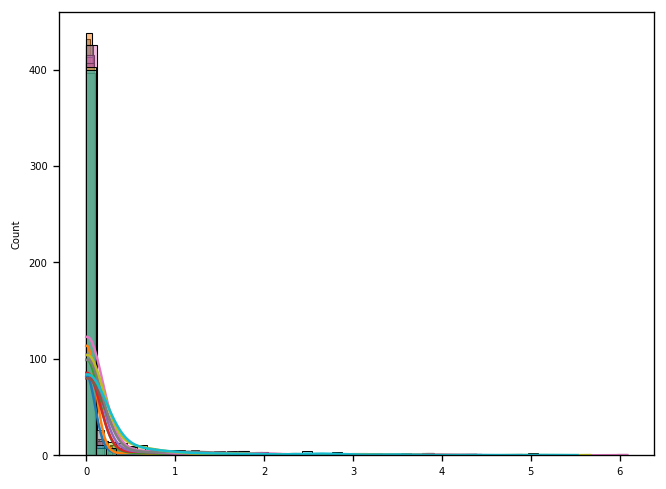

In [61]:
import seaborn as sns
for num,i in enumerate(np.linspace(0.1, 1, 10)):
    print(f"Processing i = {np.round(i,1)}")
    # Assuming these files exist in your directory
    p1 = np.load(f'dbm1_{np.round(i,1)}.npz') 
    waitlist = p1['db1mlist'].reshape(500, )
    sns.histplot(x=waitlist, bins=50, kde=True)

In [62]:


X_combined_w = np.zeros((500*10, 2))
uavwaitlist = np.zeros((500*10, 1))
waitlist = np.zeros((500*10, 1))






for num,i in enumerate(np.linspace(0.1, 1, 10)):
    print(f"Processing i = {np.round(i,1)}")
    # Assuming these files exist in your directory
    p1 = np.load(f'dbm1_{np.round(i,1)}.npz') 
    X_combined = p1['X_combined']
    ilits = np.repeat(i, 500).reshape(500, 1)
    
    waitl = p1['db1mlist'].reshape(500, 1)
    waitlist[(num*500):(num+1)*500, :] = waitl
    X_combined = np.hstack((X_combined, ilits))
    X_combined_w[(num*500):(num+1)*500, :] = X_combined
    
    uavwait = p1['uavwaitinglist'].reshape(500, 1)
    uavwaitlist[(num*500):(num+1)*500, :] = uavwait
    degree = 1 

    model_uav = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model_uav.fit(X_combined, uavwait)

    r2 = model_uav.score(X_combined, uavwait)
    linear_regression_model_uav = model_uav.named_steps['linearregression']
    coef = linear_regression_model_uav.coef_[0][1] # Assuming degree 1 and you care about the first feature
    intercept = linear_regression_model_uav.intercept_[0]

    print(f"  R^2 Score: {r2:.4f}")
    print(f"  Coefficient (X_combined[0]): {coef:.4f}")
    print(f"  Intercept: {intercept:.4f}")

    
    
    r2list.append(r2)
    klist.append(coef)
    interceptlist.append(intercept)

Processing i = 0.1
  R^2 Score: 0.9684
  Coefficient (X_combined[0]): -11.4504
  Intercept: 12.4148
Processing i = 0.2
  R^2 Score: 0.9413
  Coefficient (X_combined[0]): -11.2952
  Intercept: 12.4209
Processing i = 0.3
  R^2 Score: 0.9132
  Coefficient (X_combined[0]): -10.9147
  Intercept: -1.2110
Processing i = 0.4
  R^2 Score: 0.9060
  Coefficient (X_combined[0]): -11.2992
  Intercept: 12.5647
Processing i = 0.5
  R^2 Score: 0.8671
  Coefficient (X_combined[0]): -10.6781
  Intercept: 11.6487
Processing i = 0.6
  R^2 Score: 0.8571
  Coefficient (X_combined[0]): -10.6894
  Intercept: -9.6324
Processing i = 0.7
  R^2 Score: 0.8216
  Coefficient (X_combined[0]): -10.6870
  Intercept: 11.3771
Processing i = 0.8
  R^2 Score: 0.8382
  Coefficient (X_combined[0]): -10.8515
  Intercept: 12.1980
Processing i = 0.9
  R^2 Score: 0.7797
  Coefficient (X_combined[0]): -10.4561
  Intercept: 11.0189
Processing i = 1.0
  R^2 Score: 0.7739
  Coefficient (X_combined[0]): -10.4726
  Intercept: 11.7334


In [63]:
X_combined_w_y = np.hstack((X_combined_w, waitlist.reshape(-1, 1)))
X_combined_w_y.shape

(5000, 3)

In [64]:
import numpy as np
import pandas as pd # 方便数据处理和展示

# 继续使用上面的 X_combined_w_y 模拟数据

# 您提供的分段点
bins = [0.0] + [0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # 添加 0.0 作为起始点，确保覆盖所有数据
# 或者如果您只想分析 >=0.5 的部分，可以调整 bins

print("\n--- 分段平均值分析 ---")

# 存储每个区间的平均值
bin_means = {}

# 存储比率变化
change_ratios = {}

# 将数据按第一列排序，以便更好地理解区间
X_combined_w_y_sorted = X_combined_w_y[X_combined_w_y[:, 0].argsort()]

# 迭代分段点
for i in range(len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i+1]

    # 筛选出当前区间的数据
    # 使用包含下限，不包含上限的方式 [lower, upper)
    # 最后一个区间包含上限 [0.9, 1.0]
    if i == len(bins) - 2: # 最后一个区间
        subset_data = X_combined_w_y_sorted[
            (X_combined_w_y_sorted[:, 0] >= lower_bound) &
            (X_combined_w_y_sorted[:, 0] <= upper_bound)
        ]
    else:
        subset_data = X_combined_w_y_sorted[
            (X_combined_w_y_sorted[:, 0] >= lower_bound) &
            (X_combined_w_y_sorted[:, 0] < upper_bound)
        ]

    # 确保子集非空
    if subset_data.shape[0] > 0:
        current_mean = subset_data[:, -1].mean()
        bin_means[f"{lower_bound}-{upper_bound}"] = current_mean
        print(f"区间 [{lower_bound:.1f}, {upper_bound:.1f}) 的平均值: {current_mean:.4f} (样本数: {subset_data.shape[0]})")
    else:
        bin_means[f"{lower_bound}-{upper_bound}"] = np.nan # 如果没有数据，设为 NaN
        print(f"区间 [{lower_bound:.1f}, {upper_bound:.1f}) 无数据。")


# 计算相邻区间的平均值变化 Ratio
print("\n--- 平均值变化 Ratio ---")
mean_values = list(bin_means.values())
mean_keys = list(bin_means.keys())

max_ratio = -1.0
max_ratio_segment = ""

for i in range(len(mean_values) - 1):
    val1 = mean_values[i]
    val2 = mean_values[i+1]
    segment1 = mean_keys[i]
    segment2 = mean_keys[i+1]

    if pd.notna(val1) and pd.notna(val2) and val1 != 0: # 确保值有效且分母不为0
        # 计算比率 (val2 / val1)
        ratio = val2 / val1
        change_ratios[f"从 {segment1} 到 {segment2}"] = ratio
        print(f"平均值从 {segment1} 到 {segment2} 的比率变化: {ratio:.4f}")

        # 找到最大的比率 (绝对值最大的变化率)
        if abs(ratio) > max_ratio: # 或者 abs(ratio - 1) 来衡量远离1的程度
            max_ratio = abs(ratio)
            max_ratio_segment = f"从 {segment1} 到 {segment2}"
    else:
        print(f"无法计算从 {segment1} 到 {segment2} 的比率变化 (数据不足或为零)。")

if max_ratio_segment:
    print(f"\n平均值变化 Ratio 最大的分段是: {max_ratio_segment}, Ratio: {max_ratio:.4f}")
else:
    print("\n未能找到有效的最大比率变化。")


--- 分段平均值分析 ---
区间 [0.0, 0.5) 的平均值: 0.0005 (样本数: 2100)
区间 [0.5, 0.6) 的平均值: 0.0073 (样本数: 500)
区间 [0.6, 0.7) 的平均值: 0.0225 (样本数: 500)
区间 [0.7, 0.8) 的平均值: 0.0600 (样本数: 400)
区间 [0.8, 0.9) 的平均值: 0.1873 (样本数: 500)
区间 [0.9, 1.0) 的平均值: 0.4351 (样本数: 500)

--- 平均值变化 Ratio ---
平均值从 0.0-0.5 到 0.5-0.6 的比率变化: 15.9835
平均值从 0.5-0.6 到 0.6-0.7 的比率变化: 3.0870
平均值从 0.6-0.7 到 0.7-0.8 的比率变化: 2.6617
平均值从 0.7-0.8 到 0.8-0.9 的比率变化: 3.1231
平均值从 0.8-0.9 到 0.9-1.0 的比率变化: 2.3231

平均值变化 Ratio 最大的分段是: 从 0.0-0.5 到 0.5-0.6, Ratio: 15.9835


--- 重新计算分段平均值 ---
区间 [0.0, 0.5) 的平均值: 0.0005 (样本数: 2100)
区间 [0.5, 0.6) 的平均值: 0.0073 (样本数: 500)
区间 [0.6, 0.7) 的平均值: 0.0225 (样本数: 500)
区间 [0.7, 0.8) 的平均值: 0.0600 (样本数: 400)
区间 [0.8, 0.9) 的平均值: 0.1873 (样本数: 500)
区间 [0.9, 1.0) 的平均值: 0.4351 (样本数: 500)


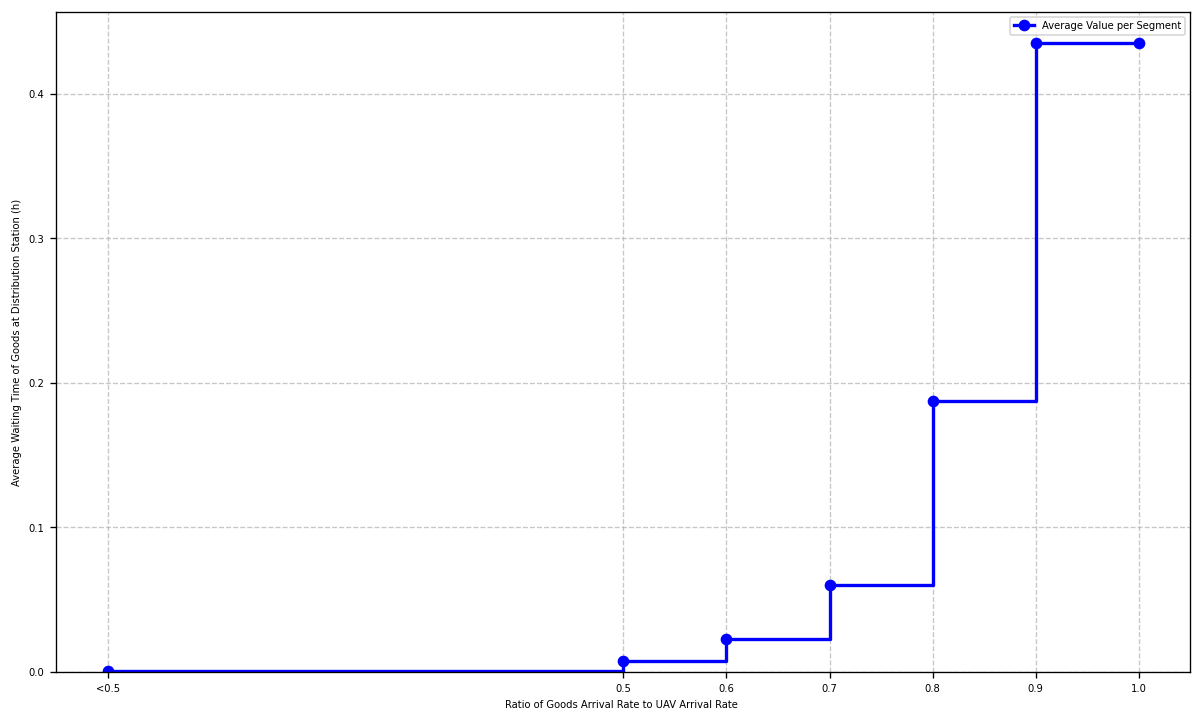


--- 分段平均值分析完成 ---
[0.00045666931217752676, 0.007299190554930361, 0.022532684270061394, 0.05997439712262835, 0.1873069810922462, 0.43513171924427196]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # 用于更精细的刻度控制


bins = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

print("--- 重新计算分段平均值 ---")




plot_x_values = [] # 用于阶梯图的X坐标 (区间的右边界)
plot_y_values = [] # 用于阶梯图的Y坐标 (区间的平均值)
segment_labels = [] # 用于打印输出

# 将数据按第一列排序 (虽然对于平均值计算不是必须，但对理解数据有帮助)
X_combined_w_y_sorted = X_combined_w_y[X_combined_w_y[:, 0].argsort()]
current_meanlist = []
for i in range(len(bins) - 1):
    lower_bound = bins[i]
    upper_bound = bins[i+1]

    # 筛选出当前区间的数据
    # 注意：最后一个区间包含上限，其他区间不包含上限
    if i == len(bins) - 2: # 最后一个区间 (例如 [0.9, 1.0])
        subset_data = X_combined_w_y_sorted[
            (X_combined_w_y_sorted[:, 0] >= lower_bound) &
            (X_combined_w_y_sorted[:, 0] <= upper_bound)
        ]
    else: # 其他区间 (例如 [0.0, 0.5), [0.5, 0.6) 等)
        subset_data = X_combined_w_y_sorted[
            (X_combined_w_y_sorted[:, 0] >= lower_bound) &
            (X_combined_w_y_sorted[:, 0] < upper_bound)
        ]

    if subset_data.shape[0] > 0:
        current_mean = subset_data[:, -1].mean()
        current_meanlist.append(current_mean)
        plot_x_values.append(upper_bound) # X轴使用区间的右边界
        plot_y_values.append(current_mean)
        segment_labels.append(f"[{lower_bound:.1f}, {upper_bound:.1f})")
        print(f"区间 [{lower_bound:.1f}, {upper_bound:.1f}) 的平均值: {current_mean:.4f} (样本数: {subset_data.shape[0]})")
    else:
        # 如果某个区间没有数据，可以在图上显示为0或者留空，这里我们跳过，不画这个点
        print(f"区间 [{lower_bound:.1f}, {upper_bound:.1f}) 无数据。")

# --- 绘制阶梯图 ---
plt.figure(figsize=(10, 6))




x_for_plot = [bins[0]] + plot_x_values[:-1] # 从第一个bin的下界开始
y_for_plot = plot_y_values

# 添加最后一个点，以完成最后一个阶梯
x_for_plot.append(bins[-1])
y_for_plot.append(plot_y_values[-1])


plt.step(x_for_plot, y_for_plot, where='post', color='blue', linestyle='-', linewidth=2, marker='o', markersize=6, label='Average Value per Segment')

# 添加标签和标题
plt.xlabel('Ratio of Goods Arrival Rate to UAV Arrival Rate ')
plt.ylabel('Average Waiting Time of Goods at Distribution Station (h)')
# plt.title('Simulation results of Stepwise Average Waiting Time of Gods at Distribution Station')
plt.grid(True, linestyle='--', alpha=0.7)




plt.xticks(bins, [f'<{bins[1]:.1f}'] + [f'{b:.1f}' for b in bins[1:]])




plt.ylim(bottom=0)

plt.legend()
plt.tight_layout()
plt.show()
print("\n--- 分段平均值分析完成 ---")
print(current_meanlist)

In [58]:
import numpy as np
import pandas as pd
import statsmodels.api as sm # 导入 statsmodels 库
from sklearn.preprocessing import StandardScaler # 用于特征标准化
from sklearn.pipeline import Pipeline # 用于构建标准化和回归的管道

# --- 1. 准备数据 (使用模拟数据，请替换为您的实际数据) ---
# 示例：假设您的 X_combined_w 是一个包含四个特征的 NumPy 数组
# 并假设这些特征的含义如下：
# Feature 0: Arrival Rate (lambda)
# Feature 1: Service Rate (mu)
# Feature 2: System Capacity
# Feature 3: Weather Condition Index
#
# 请将这些模拟数据替换为您的实际数据

target_variable_data = uavwaitlist # 请将这里替换为您的实际目标变量数据 (uavwaitlist 或 waitlist)


# --- 2. 数据标准化 ---
feature_names = ['Service rate', 'Interval time', 'lambda', 'miu']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined_w)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# --- 3. 使用 statsmodels 进行线性回归分析 ---
# statsmodels 需要显式地添加常数项 (截距)
X_scaled_df_with_const = sm.add_constant(X_scaled_df)

# 创建并拟合 OLS (Ordinary Least Squares) 模型
model_sm = sm.OLS(target_variable_data, X_scaled_df_with_const)
results_sm = model_sm.fit()

# 打印模型的详细统计摘要
print("\n--- Statsmodels 线性回归模型摘要 ---")
print(results_sm.summary())

# --- 4. 分析特征重要性 (基于系数和 p-value) ---
print("\n--- 特征重要性分析 (基于标准化系数和 p-value) ---")

# 获取系数和 p-value
coefficients = results_sm.params[1:] # 排除常数项 (截距) 的系数
p_values = results_sm.pvalues[1:] # 排除常数项的 p-value

# 创建一个 DataFrame 方便查看和排序
feature_analysis_df = pd.DataFrame({
    'Feature': feature_names,
    'Standardized_Coefficient': coefficients,
    'P_Value': p_values
})

# 按 p-value 升序排序 (p-value 越小越显著)
feature_analysis_df = feature_analysis_df.sort_values(by='P_Value').reset_index(drop=True)

print(feature_analysis_df)

# --- 5. 选择重要特征 ---
# 设定显著性水平阈值，通常取 0.05
p_value_threshold = 0.05
important_features_stats = feature_analysis_df[feature_analysis_df['P_Value'] < p_value_threshold]

if not important_features_stats.empty:
    selected_feature_names = important_features_stats['Feature'].tolist()
    print(f"\n--- 识别出的重要特征 (p-value < {p_value_threshold}) ---")
    print(selected_feature_names)

    # --- 6. 构建并展示仅包含重要特征的线性关系 ---
    # 不需要重新拟合，因为我们已经知道它们的系数（在标准化尺度下）
    # 如果要给出原始尺度下的线性关系，则需要重新拟合或进行反标准化操作

    # 为了给出原始尺度下的线性关系，我们需要只使用这些重要特征来训练一个新的 sklearn LinearRegression 模型
    # 因为 statsmodels 的系数是基于标准化数据的，直接用它们构建原始数据上的公式会不准确
    X_important_original_scale = X_combined_w[selected_feature_names]

    # 使用 sklearn 拟合原始尺度下的重要特征
    model_final_linear = Pipeline([
        ('regressor', LinearRegression()) # 不再使用PolynomialFeatures，因为degree=1
    ])
    model_final_linear.fit(X_important_original_scale, target_variable_data)

    coef_final = model_final_linear.named_steps['regressor'].coef_[0]
    intercept_final = model_final_linear.named_steps['regressor'].intercept_[0]
    r2_final = model_final_linear.score(X_important_original_scale, target_variable_data)

    print(f"\n--- 仅包含重要特征的线性模型结果 ({target_variable_name}) ---")
    print(f"  R^2 Score: {r2_final:.4f}")
    print(f"  Features: {selected_feature_names}")
    print(f"  Coefficients: {coef_final}")
    print(f"  Intercept: {intercept_final:.4f}")

    # 给出线性关系表达式
    feature_coef_map_final = dict(zip(selected_feature_names, coef_final))
    equation_parts_final = [f"{feature_coef_map_final[f]:.4f} * {f}" for f in selected_feature_names]
    linear_equation_final = f"{target_variable_name} = {intercept_final:.4f} + " + " + ".join(equation_parts_final)
    print(f"\n最终基于统计显著性筛选的重要特征的线性关系表达式:")
    print(linear_equation_final)

else:
    print(f"\n没有特征在 p-value < {p_value_threshold} 的阈值下被认定为统计显著。")
    print("这可能意味着所有特征对目标变量的线性影响都不显著，或者数据量不足以检测到显著性。")

# 您可以对 waitlist 重复以上过程，只需更改 target_variable_name 和 target_variable_data


--- Statsmodels 线性回归模型摘要 ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     6551.
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        09:13:57   Log-Likelihood:                -7853.0
No. Observations:                4500   AIC:                         1.572e+04
Df Residuals:                    4495   BIC:                         1.575e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm # 导入 statsmodels 库
from sklearn.preprocessing import StandardScaler # 用于特征标准化
from sklearn.pipeline import Pipeline # 用于构建标准化和回归的管道


# 请将这些模拟数据替换为您的实际数据
uavwaitlist_log_plus_epsilon = np.log(waitlist + 1e-5)  # 添加一个小的正数以避免对数为负无穷大
target_variable_data = uavwaitlist_log_plus_epsilon
target_variable_data = target_variable_data

# --- 2. 数据标准化 ---
X_combined_w = X_combined_w[:, 0].reshape(-1, 1)
feature_names = ['Service rate']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined_w)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# --- 3. 使用 statsmodels 进行线性回归分析 ---
# statsmodels 需要显式地添加常数项 (截距)
X_scaled_df_with_const = sm.add_constant(X_scaled_df)

# 创建并拟合 OLS (Ordinary Least Squares) 模型
model_sm = sm.OLS(target_variable_data, X_scaled_df_with_const)
results_sm = model_sm.fit()

# 打印模型的详细统计摘要
print("\n--- Statsmodels 线性回归模型摘要 ---")
print(results_sm.summary())

# --- 4. 分析特征重要性 (基于系数和 p-value) ---
print("\n--- 特征重要性分析 (基于标准化系数和 p-value) ---")

# 获取系数和 p-value
coefficients = results_sm.params[1:] # 排除常数项 (截距) 的系数
p_values = results_sm.pvalues[1:] # 排除常数项的 p-value

# 创建一个 DataFrame 方便查看和排序
feature_analysis_df = pd.DataFrame({
    'Feature': feature_names,
    'Standardized_Coefficient': coefficients,
    'P_Value': p_values
})

# 按 p-value 升序排序 (p-value 越小越显著)
feature_analysis_df = feature_analysis_df.sort_values(by='P_Value').reset_index(drop=True)

print(feature_analysis_df)

# --- 5. 选择重要特征 ---
# 设定显著性水平阈值，通常取 0.05
p_value_threshold = 0.05
important_features_stats = feature_analysis_df[feature_analysis_df['P_Value'] < p_value_threshold]

if not important_features_stats.empty:
    selected_feature_names = important_features_stats['Feature'].tolist()
    print(f"\n--- 识别出的重要特征 (p-value < {p_value_threshold}) ---")
    print(selected_feature_names)

    # --- 6. 构建并展示仅包含重要特征的线性关系 ---
    # 不需要重新拟合，因为我们已经知道它们的系数（在标准化尺度下）
    # 如果要给出原始尺度下的线性关系，则需要重新拟合或进行反标准化操作

    # 为了给出原始尺度下的线性关系，我们需要只使用这些重要特征来训练一个新的 sklearn LinearRegression 模型
    # 因为 statsmodels 的系数是基于标准化数据的，直接用它们构建原始数据上的公式会不准确
    X_important_original_scale = X_combined_w[selected_feature_names]

    # 使用 sklearn 拟合原始尺度下的重要特征
    model_final_linear = Pipeline([
        ('regressor', LinearRegression()) # 不再使用PolynomialFeatures，因为degree=1
    ])
    model_final_linear.fit(X_important_original_scale, target_variable_data)

    coef_final = model_final_linear.named_steps['regressor'].coef_[0]
    intercept_final = model_final_linear.named_steps['regressor'].intercept_[0]
    r2_final = model_final_linear.score(X_important_original_scale, target_variable_data)

    print(f"\n--- 仅包含重要特征的线性模型结果 ({target_variable_name}) ---")
    print(f"  R^2 Score: {r2_final:.4f}")
    print(f"  Features: {selected_feature_names}")
    print(f"  Coefficients: {coef_final}")
    print(f"  Intercept: {intercept_final:.4f}")

    # 给出线性关系表达式
    feature_coef_map_final = dict(zip(selected_feature_names, coef_final))
    equation_parts_final = [f"{feature_coef_map_final[f]:.4f} * {f}" for f in selected_feature_names]
    linear_equation_final = f"{target_variable_name} = {intercept_final:.4f} + " + " + ".join(equation_parts_final)
    print(f"\n最终基于统计显著性筛选的重要特征的线性关系表达式:")
    print(linear_equation_final)

else:
    print(f"\n没有特征在 p-value < {p_value_threshold} 的阈值下被认定为统计显著。")
    print("这可能意味着所有特征对目标变量的线性影响都不显著，或者数据量不足以检测到显著性。")

# 您可以对 waitlist 重复以上过程，只需更改 target_variable_name 和 target_variable_data


--- Statsmodels 线性回归模型摘要 ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     4246.
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        09:14:07   Log-Likelihood:                -11592.
No. Observations:                4500   AIC:                         2.319e+04
Df Residuals:                    4498   BIC:                         2.320e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -8

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [53]:
import numpy as np
import pandas as pd
import statsmodels.api as sm # 导入 statsmodels 库
from sklearn.preprocessing import StandardScaler # 用于特征标准化
from sklearn.pipeline import Pipeline # 用于构建标准化和回归的管道

# --- 1. 准备数据 (使用模拟数据，请替换为您的实际数据) ---
# 示例：假设您的 X_combined_w 是一个包含四个特征的 NumPy 数组
# 并假设这些特征的含义如下：
# Feature 0: Arrival Rate (lambda)
# Feature 1: Service Rate (mu)
# Feature 2: System Capacity
# Feature 3: Weather Condition Index
#
# 请将这些模拟数据替换为您的实际数据
uavwaitlist_log_plus_epsilon = waitlist  # 添加一个小的正数以避免对数为负无穷大
target_variable_data = uavwaitlist_log_plus_epsilon
target_variable_data = target_variable_data

# --- 2. 数据标准化 ---
feature_names = ['Service rate', 'Interval time', 'lambda', 'miu']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined_w)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# --- 3. 使用 statsmodels 进行线性回归分析 ---
# statsmodels 需要显式地添加常数项 (截距)
X_scaled_df_with_const = sm.add_constant(X_scaled_df)

# 创建并拟合 OLS (Ordinary Least Squares) 模型
model_sm = sm.OLS(target_variable_data, X_scaled_df_with_const)
results_sm = model_sm.fit()

# 打印模型的详细统计摘要
print("\n--- Statsmodels 线性回归模型摘要 ---")
print(results_sm.summary())

# --- 4. 分析特征重要性 (基于系数和 p-value) ---
print("\n--- 特征重要性分析 (基于标准化系数和 p-value) ---")

# 获取系数和 p-value
coefficients = results_sm.params[1:] # 排除常数项 (截距) 的系数
p_values = results_sm.pvalues[1:] # 排除常数项的 p-value

# 创建一个 DataFrame 方便查看和排序
feature_analysis_df = pd.DataFrame({
    'Feature': feature_names,
    'Standardized_Coefficient': coefficients,
    'P_Value': p_values
})

# 按 p-value 升序排序 (p-value 越小越显著)
feature_analysis_df = feature_analysis_df.sort_values(by='P_Value').reset_index(drop=True)

print(feature_analysis_df)

# --- 5. 选择重要特征 ---
# 设定显著性水平阈值，通常取 0.05
p_value_threshold = 0.05
important_features_stats = feature_analysis_df[feature_analysis_df['P_Value'] < p_value_threshold]

if not important_features_stats.empty:
    selected_feature_names = important_features_stats['Feature'].tolist()
    print(f"\n--- 识别出的重要特征 (p-value < {p_value_threshold}) ---")
    print(selected_feature_names)

    # --- 6. 构建并展示仅包含重要特征的线性关系 ---
    # 不需要重新拟合，因为我们已经知道它们的系数（在标准化尺度下）
    # 如果要给出原始尺度下的线性关系，则需要重新拟合或进行反标准化操作

    # 为了给出原始尺度下的线性关系，我们需要只使用这些重要特征来训练一个新的 sklearn LinearRegression 模型
    # 因为 statsmodels 的系数是基于标准化数据的，直接用它们构建原始数据上的公式会不准确
    X_important_original_scale = X_combined_w[selected_feature_names]

    # 使用 sklearn 拟合原始尺度下的重要特征
    model_final_linear = Pipeline([
        ('regressor', LinearRegression()) # 不再使用PolynomialFeatures，因为degree=1
    ])
    model_final_linear.fit(X_important_original_scale, target_variable_data)

    coef_final = model_final_linear.named_steps['regressor'].coef_[0]
    intercept_final = model_final_linear.named_steps['regressor'].intercept_[0]
    r2_final = model_final_linear.score(X_important_original_scale, target_variable_data)

    print(f"\n--- 仅包含重要特征的线性模型结果 ({target_variable_name}) ---")
    print(f"  R^2 Score: {r2_final:.4f}")
    print(f"  Features: {selected_feature_names}")
    print(f"  Coefficients: {coef_final}")
    print(f"  Intercept: {intercept_final:.4f}")

    # 给出线性关系表达式
    feature_coef_map_final = dict(zip(selected_feature_names, coef_final))
    equation_parts_final = [f"{feature_coef_map_final[f]:.4f} * {f}" for f in selected_feature_names]
    linear_equation_final = f"{target_variable_name} = {intercept_final:.4f} + " + " + ".join(equation_parts_final)
    print(f"\n最终基于统计显著性筛选的重要特征的线性关系表达式:")
    print(linear_equation_final)

else:
    print(f"\n没有特征在 p-value < {p_value_threshold} 的阈值下被认定为统计显著。")
    print("这可能意味着所有特征对目标变量的线性影响都不显著，或者数据量不足以检测到显著性。")

# 您可以对 waitlist 重复以上过程，只需更改 target_variable_name 和 target_variable_data


--- Statsmodels 线性回归模型摘要 ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     249.3
Date:                Mon, 26 May 2025   Prob (F-statistic):          1.07e-193
Time:                        08:49:42   Log-Likelihood:                -3383.7
No. Observations:                4500   AIC:                             6777.
Df Residuals:                    4495   BIC:                             6809.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [95]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler # 引入 StandardScaler
from sklearn.pipeline import make_pipeline
import shap # 导入 shap 库
import matplotlib.pyplot as plt

# --- 1. 准备数据 (使用模拟数据，请替换为您的实际数据) ---
# 假设 X_combined_w 包含四个特征
# 为了演示，我们模拟一个包含4个特征的DataFrame，并给它们命名，方便后续SHAP解释

degree = 1
model_pipeline = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# 拟合模型
model_pipeline.fit(X_combined_w, uavwaitlist)

# 提取线性回归模型部分
linear_reg_model = model_pipeline.named_steps['linearregression']
# 提取 PolynomialFeatures 部分，以便知道哪些是原始特征，哪些是多项式特征（如果 degree > 1）
poly_features_transformer = model_pipeline.named_steps['polynomialfeatures']

# 获取拟合后的系数和截距
coef = linear_reg_model.coef_
intercept = linear_reg_model.intercept_[0]

print("\n--- 原始线性回归模型结果 ---")
print(f"R^2 Score: {model_pipeline.score(X_combined_w, uavwaitlist):.4f}")
print(f"Coefficients: {coef}")
print(f"Intercept: {intercept:.4f}")

# --- 3. 使用 SHAP 解释模型 ---
# For LinearRegression, shap.LinearExplainer is suitable and very fast.
# If you used a different model (e.g., RandomForestRegressor), you would use shap.TreeExplainer or shap.KernelExplainer.

# LinearExplainer 需要模型和数据 (通常是训练数据或其子集作为 background_data)
# 对于线性模型，SHAP值直接对应于特征对预测的贡献。
# 注意：如果您的pipeline包含了StandardScaler，explainer需要作用在scaler后的数据上
# 或者更简单，直接使用LinearExplainer对LinearRegression模型本身解释经过PolynomialFeatures转换后的数据

# 获取经过 PolynomialFeatures 转换后的特征名称
t

SystemError: initialization of _internal failed without raising an exception

In [ ]:
ransformed_feature_names = poly_features_transformer.get_feature_names_out(X_combined_w.columns)
X_transformed = poly_features_transformer.transform(X_combined_w)
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_feature_names)


# 使用 shap.LinearExplainer
# explainer = shap.LinearExplainer(linear_reg_model, X_transformed_df) # 如果X_transformed_df是经过StandardScaler的，这里应该用scaler后的数据
explainer = shap.LinearExplainer(linear_reg_model, X_transformed_df, feature_dependence="independent") # For linear models, 'independent' is often good

# 计算 SHAP 值
shap_values = explainer.shap_values(X_transformed_df)

# --- 4. SHAP 结果可视化和重要特征提取 ---

print("\n--- SHAP 特征重要性分析 ---")

# SHAP Summary Plot (全局特征重要性)
# 可以看到每个特征的SHAP值分布，以及其对预测的正负影响
shap.summary_plot(shap_values, X_transformed_df, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Mean Absolute SHAP Value)")
plt.show()

# SHAP Summary Plot (详细视图)
# 更详细地显示每个特征值对预测的影响
shap.summary_plot(shap_values, X_transformed_df, show=False)
plt.title("SHAP Feature Contribution")
plt.show()


# 提取全局重要特征（按平均绝对SHAP值排序）
# 线性回归的SHAP值对于每个特征就是其系数乘以特征值，所以mean(|SHAP|)会与|coef|相关
# 对于PolynomialFeatures(degree=1)，_transformed_feature_names[1:] 对应原始特征
feature_importance = pd.DataFrame({
    'Feature': X_combined_w.columns, # 原始特征名称
    'Mean_Abs_SHAP': np.mean(np.abs(shap_values[:, 1:]), axis=0), # 忽略偏置项（第一个特征）的SHAP值
    'Coefficient': coef[0] # 提取系数
})
feature_importance = feature_importance.sort_values(by='Mean_Abs_SHAP', ascending=False)

print("\n--- 全局特征重要性 (按平均绝对SHAP值排序) ---")
print(feature_importance)


# --- 5. 根据 SHAP 结果给出线性关系 ---

# 定义一个阈值来选择“重要”特征，例如，选择前N个特征，或者平均绝对SHAP值大于某个值的特征
# 这里我们选择前3个最重要的特征作为示例
n_important_features = 3
important_features = feature_importance['Feature'].head(n_important_features).tolist()

print(f"\n--- 基于 SHAP 识别出的 {n_important_features} 个重要特征 ---")
print(f"重要特征列表: {important_features}")

# 重新构建只包含这些重要特征的线性模型 (方法B)
# 如果您想直接从原模型中看这些特征的系数（方法A），可以直接从上面打印的 `coef` 中查找。
# 重新拟合可以得到一个新的，只包含重要特征的线性模型
X_important = X_combined_w[important_features] # 选择原始DataFrame中的重要特征列

model_important = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_important.fit(X_important, uavwaitlist)

coef_important = model_important.named_steps['linearregression'].coef_
intercept_important = model_important.named_steps['linearregression'].intercept_[0]
r2_important = model_important.score(X_important, uavwaitlist)

print(f"\n--- 仅包含重要特征的线性模型结果 (uavwaitlist) ---")
print(f"R^2 Score: {r2_important:.4f}")
print(f"Features: {important_features}")
print(f"Coefficients: {coef_important}")
print(f"Intercept: {intercept_important:.4f}")

# 给出线性关系表达式
feature_coef_map = dict(zip(important_features, coef_important[0]))
equation_parts = [f"{feature_coef_map[f]:.4f} * {f}" for f in important_features]
linear_equation = f"uavwaitlist = {intercept_important:.4f} + " + " + ".join(equation_parts)
print(f"\n线性关系表达式:")
print(linear_equation)

# 您可以对 waitlist 重复以上过程

<Axes: ylabel='Count'>

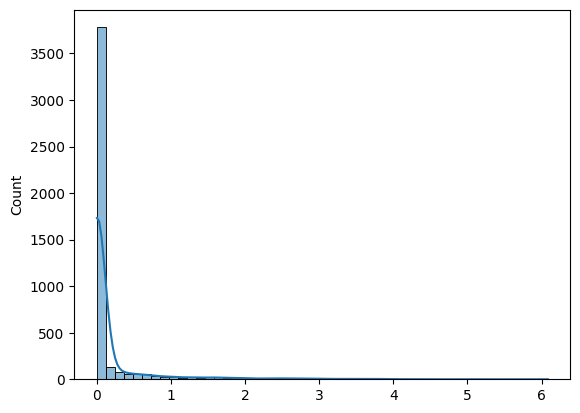

In [28]:
import seaborn as sns
waitlist = waitlist.reshape(4500, )
sns.histplot(x=waitlist, bins=50, kde=True)

In [27]:
waitlist

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.05297971],
       [0.09075896],
       [0.04323713]])

In [29]:
waitlist.max()

6.085712713312291

In [69]:
r2list = np.array(r2list)
klist = np.array(klist)
interceptlist = np.array(interceptlist)
np.save(r'r2list2-10.npy', r2list)
np.save(r'klist2-10.npy', klist)
np.save(r'interceptlist2-10.npy', interceptlist)

In [ ]:
import matplotlib.pyplot as plt


In [70]:


import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt



X_combined = np.load('X_combined3.npy')
uavwaitinglist = np.load('uavwaitinglist3.npy')
degree = 1 # 你可以根据数据关系调整这个值
X_combined = X_combined[:, 0].reshape(-1, 1)  # 确保 X_combined 是二维的
# --- 拟合 uavwaitinglist ---
print("\n--- 拟合 uavwaitinglist ---")
model_uav = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_uav.fit(X_combined, uavwaitinglist)

y_pred_uav = model_uav.predict(X_combined)

print(f"UAV Waiting List 拟合 R^2 Score: {model_uav.score(X_combined, uavwaitinglist):.4f}")

# Extracting parameters for uavwaitinglist model
# The LinearRegression model is the last step in the pipeline
linear_regression_model_uav = model_uav.named_steps['linearregression']
print(f"UAV Waiting List Coefficients: {linear_regression_model_uav.coef_}")
print(f"UAV Waiting List Intercept: {linear_regression_model_uav.intercept_:.4f}")




--- 拟合 uavwaitinglist ---
UAV Waiting List 拟合 R^2 Score: 0.9698
UAV Waiting List Coefficients: [  0.        -11.3452879]
UAV Waiting List Intercept: 11.8880


In [75]:
r2 = model_uav.score(X_combined, uavwaitinglist)
k = linear_regression_model_uav.coef_[1]
intercept = linear_regression_model_uav.intercept_

In [80]:
r2list = np.load('r2list2-10.npy')
klist = np.load('klist2-10.npy')
interceptlist = np.load('interceptlist2-10.npy')
r2_new = np.append(r2, r2list)
k_new = np.append(k, klist)
intercept_new = np.append(intercept, interceptlist)

In [93]:
np.save('r2list1-10.npy', r2_new)
np.save('klist1-10.npy', k_new)
np.save('interceptlist1-10.npy', intercept_new)

In [5]:
k1 = np.load('klist1-10.npy')
inter = np.load('interceptlist1-10.npy')
print(k1.shape)

(10,)


In [6]:
k1.mean(), inter.mean()

(-10.8689098382335, 11.770618789405889)

In [10]:
k1.mean()*1+ inter.mean()

0.9017089511723881

In [11]:
k1.mean()*0.5 + inter.mean()

6.3361638702891385

In [ ]:
lambda/miu*lambda

In [ ]:
miu/lambda*lambda

In [ ]:
(k1*miu/lambda+b)*lambda

array([11.88804192, 11.91900142, 11.6677099 , 12.06099177, 11.64872591,
       11.57491446, 11.82570042, 11.76728244, 11.62046836, 11.7333513 ])

In [12]:
k1.mean(), inter.mean()

(-10.8689098382335, 11.770618789405889)

In [ ]:
(k1*miu/lambda+b)*lambda

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import simpy
import random
# 定义实验参数
uavexp_rates = np.linspace(0.01, 0.019, 10)  # 不同的 UAV 到达率
arrivalrates = np.linspace(0.001, 0.01, 10)    # 不同的货物到达率
errors = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差
errorsuav = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差
mm1_wlist = []
db1mlist = []
uavclist = []
uavwaitinglist = []
ratiolist = []
# 实验循环
ratiolist = np.linspace(0.05, 1.1, 20)
for arrivalrate in arrivalrates:
    for ratio in ratiolist:
        # 计算理论值和模拟值
        # mu = uavexp_rate
        lambda_ = arrivalrate
        mu = lambda_ * ratio
        uavclist.append(mu)
        mm1_w = 1 / (1/mu - 1/lambda_)
        uavexp_rate = mu
        mm1_wlist.append(mm1_w)
        goodsarrivetime_mean = 0.2  
        goodsexp_mean = 1/arrivalrate*goodsarrivetime_mean        # Average number of goods per batch


        env = simpy.Environment()
        station = DBMDistributionStation2(env, goodsarrivetime_mean, goodsexp_mean, uavexp_rate)

        simulation_duration = 24
        env.run(until=simulation_duration)

        dbm1_w = station.global_goods_waitingtime / station.global_goods_num
        db1mlist.append(dbm1_w)

        dm1uav = station.global_uav_waitingtime / station.global_uav_num
        uavwaitinglist.append(dm1uav)

In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [7]:


matrix = np.tile(ratiolist, (10, ))
arrivalratematrix = np.repeat(arrivalrates, 50)
uavwaitinglist = np.array(uavwaitinglist)
db1mlist = np.array(db1mlist)
uavclist = np.array(uavclist)

print(f"matrix 长度: {len(matrix)}")
print(f"arrivalratematrix 长度: {len(arrivalratematrix)}")
print(f"uavwaitinglist 长度: {len(uavwaitinglist)}")
print(f"db1mlist 长度: {len(db1mlist)}")

# 将输入特征组合成一个 (n_samples, n_features) 的矩阵
# 这里的 n_features 是 2 (matrix 和 arrivalratematrix)
X_combined = np.column_stack((matrix, ))

print(f"X_combined 形状: {X_combined.shape}")

matrix 长度: 500
arrivalratematrix 长度: 500
uavwaitinglist 长度: 500
db1mlist 长度: 500
X_combined 形状: (500, 1)


In [ ]:


# 确保所有数组的长度相
print(f"matrix 长度: {len(matrix)}")
print(f"arrivalratematrix 长度: {len(arrivalratematrix)}")
print(f"uavwaitinglist 长度: {len(uavwaitinglist)}")
print(f"db1mlist 长度: {len(db1mlist)}")

# 将输入特征组合成一个 (n_samples, n_features) 的矩阵
# 这里的 n_features 是 2 (matrix 和 arrivalratematrix)
X_combined = np.column_stack((matrix,arrivalratematrix))
print(f"X_combined 形状: {X_combined.shape}")



matrix 长度: 500
arrivalratematrix 长度: 500
uavwaitinglist 长度: 500
db1mlist 长度: 500
X_combined 形状: (500, 2)


In [336]:
degree = 1 # 你可以根据数据关系调整这个值

# --- 拟合 uavwaitinglist ---
print("\n--- 拟合 uavwaitinglist ---")
model_uav = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_uav.fit(X_combined, uavwaitinglist)

y_pred_uav = model_uav.predict(X_combined)

print(f"UAV Waiting List 拟合 R^2 Score: {model_uav.score(X_combined, uavwaitinglist):.4f}")

# Extracting parameters for uavwaitinglist model
# The LinearRegression model is the last step in the pipeline
linear_regression_model_uav = model_uav.named_steps['linearregression']
print(f"UAV Waiting List Coefficients: {linear_regression_model_uav.coef_}")
print(f"UAV Waiting List Intercept: {linear_regression_model_uav.intercept_:.4f}")


# --- 拟合 db1mlist ---
print("\n--- 拟合 db1mlist ---")
model_db1m = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_db1m.fit(X_combined, db1mlist)

y_pred_db1m = model_db1m.predict(X_combined)

print(f"DB1M List 拟合 R^2 Score: {model_db1m.score(X_combined, db1mlist):.4f}")

# Extracting parameters for db1mlist model
# The LinearRegression model is the last step in the pipeline
linear_regression_model_db1m = model_db1m.named_steps['linearregression']
print(f"DB1M List Coefficients: {linear_regression_model_db1m.coef_}")
print(f"DB1M List Intercept: {linear_regression_model_db1m.intercept_:.4f}")


--- 拟合 uavwaitinglist ---
UAV Waiting List 拟合 R^2 Score: 0.9698
UAV Waiting List Coefficients: [  0.         -11.3452879    3.99589247]
UAV Waiting List Intercept: 11.8661

--- 拟合 db1mlist ---
DB1M List 拟合 R^2 Score: 0.1768
DB1M List Coefficients: [ 0.          0.44863892 -8.23456523]
DB1M List Intercept: -0.1227


In [337]:
np.save('uavwaitinglist3.npy', uavwaitinglist)
np.save('db1mlist3.npy', db1mlist)
np.save('X_combined3.npy', X_combined)

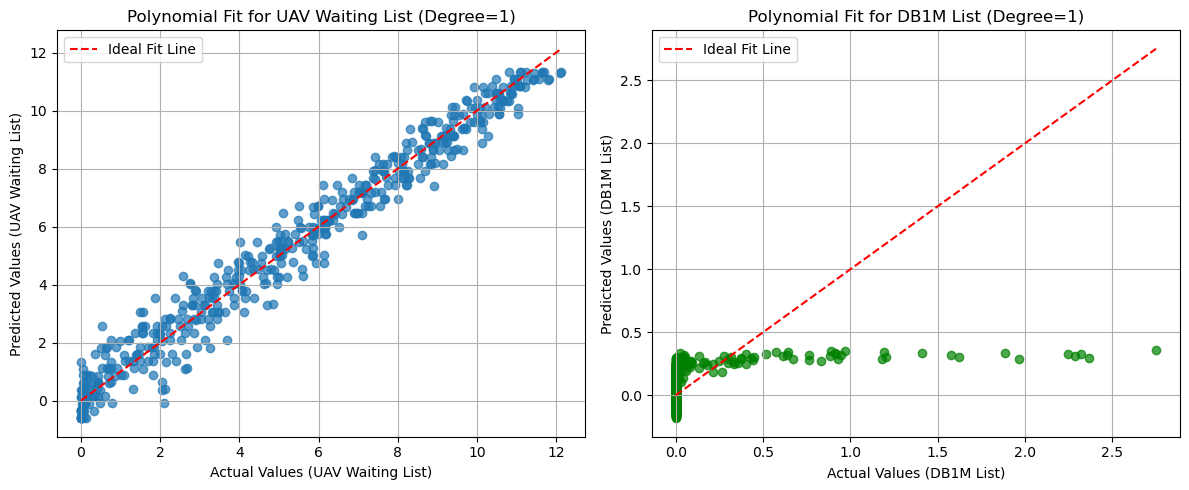


--- Partial Prediction Results ---
UAV Waiting List (Actual vs. Predicted):
  Actual: 11.64, Predicted: 11.30
  Actual: 11.79, Predicted: 11.06
  Actual: 10.67, Predicted: 10.82
  Actual: 10.56, Predicted: 10.57
  Actual: 9.75, Predicted: 10.33

DB1M List (Actual vs. Predicted):
  Actual: 0.00, Predicted: -0.11
  Actual: 0.00, Predicted: -0.10
  Actual: 0.00, Predicted: -0.09
  Actual: 0.00, Predicted: -0.08
  Actual: 0.00, Predicted: -0.07


In [341]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(uavwaitinglist, y_pred_uav, alpha=0.7)
plt.plot([min(uavwaitinglist), max(uavwaitinglist)],
         [min(uavwaitinglist), max(uavwaitinglist)],
         color='red', linestyle='--', label='Ideal Fit Line')
plt.xlabel("Actual Values (UAV Waiting List)")
plt.ylabel("Predicted Values (UAV Waiting List)")
plt.title(f"Polynomial Fit for UAV Waiting List (Degree={degree})")
plt.grid(True)
plt.legend()

# --- Visualize DB1M List Fit Results ---
plt.subplot(1, 2, 2)
plt.scatter(db1mlist, y_pred_db1m, alpha=0.7, color='green')
plt.plot([min(db1mlist), max(db1mlist)],
         [min(db1mlist), max(db1mlist)],
         color='red', linestyle='--', label='Ideal Fit Line') # Changed label here too
plt.xlabel("Actual Values (DB1M List)")
plt.ylabel("Predicted Values (DB1M List)")
plt.title(f"Polynomial Fit for DB1M List (Degree={degree})")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# --- Display Partial Prediction Results ---
print("\n--- Partial Prediction Results ---")
print("UAV Waiting List (Actual vs. Predicted):")
for i in range(5):
    print(f"  Actual: {uavwaitinglist[i]:.2f}, Predicted: {y_pred_uav[i]:.2f}")

print("\nDB1M List (Actual vs. Predicted):")
for i in range(5):
    print(f"  Actual: {db1mlist[i]:.2f}, Predicted: {y_pred_db1m[i]:.2f}")

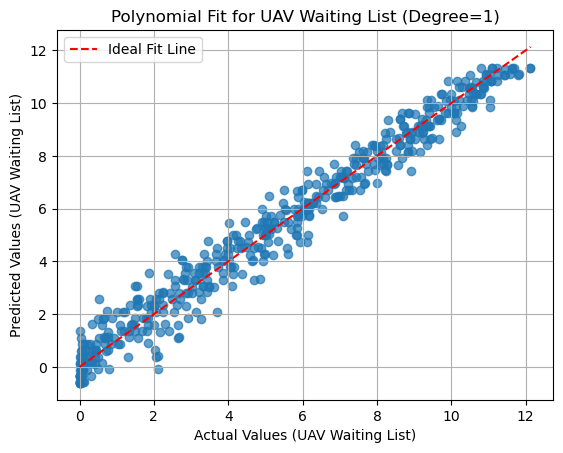

In [342]:
plt.scatter(uavwaitinglist, y_pred_uav, alpha=0.7)
plt.plot([min(uavwaitinglist), max(uavwaitinglist)],
         [min(uavwaitinglist), max(uavwaitinglist)],
         color='red', linestyle='--', label='Ideal Fit Line')
plt.xlabel("Actual Values (UAV Waiting List)")
plt.ylabel("Predicted Values (UAV Waiting List)")
plt.title(f"Polynomial Fit for UAV Waiting List (Degree={degree})")
plt.grid(True)
plt.legend()

In [ ]:
X_combined = np.load('X_combined3.npy')
uavwaitinglist = np.load('uavwaitinglist3.npy')
db1mlist = np.load('db1mlist3.npy')
X_combined

In [353]:
r2list = []
interlist = []
klist = []
for i in range(10):
    X_combined = np.load('X_combined3.npy')
    uavwaitinglist = np.load('uavwaitinglist3.npy')
    db1mlist = np.load('db1mlist3.npy')
    ratiolist = X_combined[i*50:(i+1)*50, 0]
    ratiolist = ratiolist.reshape(50, 1)
    degree = 1 # 你可以根据数据关系调整这个值

    uavwaitinglist = uavwaitinglist[i*50:(i+1)*50]
    db1mlist = db1mlist[i*50:(i+1)*50]
    model_uav = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    X_combined = ratiolist
    model_uav.fit(X_combined, uavwaitinglist)

    y_pred_uav = model_uav.predict(X_combined)

    print(f"UAV Waiting List 拟合 R^2 Score: {model_uav.score(X_combined, uavwaitinglist):.4f}")
    r2list.append(model_uav.score(X_combined, uavwaitinglist))
    # Extracting parameters for uavwaitinglist model
    # The LinearRegression model is the last step in the pipeline
    linear_regression_model_uav = model_uav.named_steps['linearregression']
    print(f"UAV Waiting List Coefficients: {linear_regression_model_uav.coef_}")
    print(f"UAV Waiting List Intercept: {linear_regression_model_uav.intercept_:.4f}")
    interlist.append(linear_regression_model_uav.intercept_)
    klist.append(linear_regression_model_uav.coef_[1])
    # --- 拟合 db1mlist ---
    print("\n--- 拟合 db1mlist ---")
    model_db1m = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model_db1m.fit(X_combined, db1mlist)

    y_pred_db1m = model_db1m.predict(X_combined)

    print(f"DB1M List 拟合 R^2 Score: {model_db1m.score(X_combined, db1mlist):.4f}")

    # Extracting parameters for db1mlist model
    # The LinearRegression model is the last step in the pipeline
    linear_regression_model_db1m = model_db1m.named_steps['linearregression']
    print(f"DB1M List Coefficients: {linear_regression_model_db1m.coef_}")
    print(f"DB1M List Intercept: {linear_regression_model_db1m.intercept_:.4f}")

UAV Waiting List 拟合 R^2 Score: 0.9642
UAV Waiting List Coefficients: [  0.         -11.29716712]
UAV Waiting List Intercept: 11.9027

--- 拟合 db1mlist ---
DB1M List 拟合 R^2 Score: 0.1754
DB1M List Coefficients: [0.         0.56311384]
DB1M List Intercept: -0.2136
UAV Waiting List 拟合 R^2 Score: 0.9830
UAV Waiting List Coefficients: [  0.        -11.6224977]
UAV Waiting List Intercept: 11.9591

--- 拟合 db1mlist ---
DB1M List 拟合 R^2 Score: 0.2795
DB1M List Coefficients: [0.         0.42649173]
DB1M List Intercept: -0.1575
UAV Waiting List 拟合 R^2 Score: 0.9737
UAV Waiting List Coefficients: [  0.         -11.59799417]
UAV Waiting List Intercept: 12.0258

--- 拟合 db1mlist ---
DB1M List 拟合 R^2 Score: 0.3001
DB1M List Coefficients: [0.         0.59718654]
DB1M List Intercept: -0.2188
UAV Waiting List 拟合 R^2 Score: 0.9777
UAV Waiting List Coefficients: [  0.         -11.29135539]
UAV Waiting List Intercept: 11.9452

--- 拟合 db1mlist ---
DB1M List 拟合 R^2 Score: 0.2079
DB1M List Coefficients: [0.    

In [357]:
np.save('klist.npy', klist)
np.save('interlist.npy', interlist)
np.save('r2list.npy', r2list)

In [8]:
degree = 1 # 你可以根据数据关系调整这个值

# --- 拟合 uavwaitinglist ---
print("\n--- 拟合 uavwaitinglist ---")
model_uav = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_uav.fit(X_combined, uavwaitinglist)

y_pred_uav = model_uav.predict(X_combined)

print(f"UAV Waiting List 拟合 R^2 Score: {model_uav.score(X_combined, uavwaitinglist):.4f}")

# Extracting parameters for uavwaitinglist model
# The LinearRegression model is the last step in the pipeline
linear_regression_model_uav = model_uav.named_steps['linearregression']
print(f"UAV Waiting List Coefficients: {linear_regression_model_uav.coef_}")
print(f"UAV Waiting List Intercept: {linear_regression_model_uav.intercept_:.4f}")


# --- 拟合 db1mlist ---
print("\n--- 拟合 db1mlist ---")
model_db1m = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_db1m.fit(X_combined, db1mlist)

y_pred_db1m = model_db1m.predict(X_combined)

print(f"DB1M List 拟合 R^2 Score: {model_db1m.score(X_combined, db1mlist):.4f}")

# Extracting parameters for db1mlist model
# The LinearRegression model is the last step in the pipeline
linear_regression_model_db1m = model_db1m.named_steps['linearregression']
print(f"DB1M List Coefficients: {linear_regression_model_db1m.coef_}")
print(f"DB1M List Intercept: {linear_regression_model_db1m.intercept_:.4f}")


--- 拟合 uavwaitinglist ---
UAV Waiting List 拟合 R^2 Score: 0.9466
UAV Waiting List Coefficients: [  0.         -11.27714525]
UAV Waiting List Intercept: 11.8842

--- 拟合 db1mlist ---
DB1M List 拟合 R^2 Score: 0.1727
DB1M List Coefficients: [0.         0.53776157]
DB1M List Intercept: -0.1955


In [9]:
X_combined.shape

(500, 1)

In [10]:


import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt



X_combined = np.load('X_combined3.npy')
uavwaitinglist = np.load('uavwaitinglist3.npy')
degree = 1 # 你可以根据数据关系调整这个值
X_combined = X_combined[:, 0].reshape(-1, 1)  # 确保 X_combined 是二维的
# --- 拟合 uavwaitinglist ---
print("\n--- 拟合 uavwaitinglist ---")
model_uav = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_uav.fit(X_combined, uavwaitinglist)

y_pred_uav = model_uav.predict(X_combined)

print(f"UAV Waiting List 拟合 R^2 Score: {model_uav.score(X_combined, uavwaitinglist):.4f}")

# Extracting parameters for uavwaitinglist model
# The LinearRegression model is the last step in the pipeline
linear_regression_model_uav = model_uav.named_steps['linearregression']
print(f"UAV Waiting List Coefficients: {linear_regression_model_uav.coef_}")
print(f"UAV Waiting List Intercept: {linear_regression_model_uav.intercept_:.4f}")




--- 拟合 uavwaitinglist ---
UAV Waiting List 拟合 R^2 Score: 0.9698
UAV Waiting List Coefficients: [  0.        -11.3452879]
UAV Waiting List Intercept: 11.8880


(500, 2)


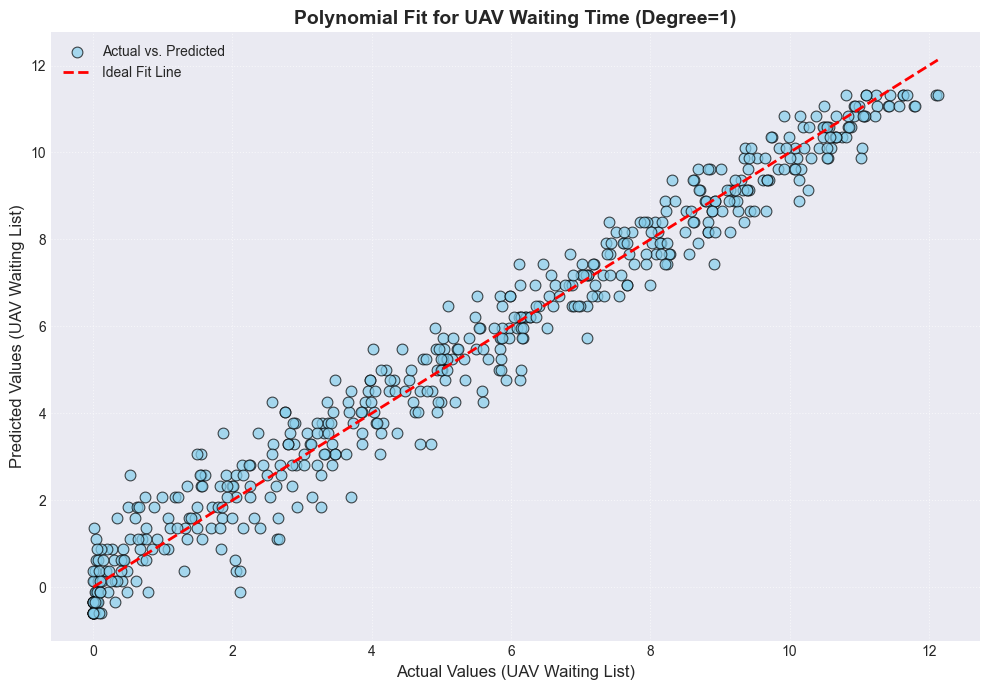

In [11]:
import matplotlib.pyplot as plt
import numpy as np # Assuming you have numpy for sample data or calculations



# Apply a plotting style for a cleaner look
# Common styles include 'ggplot', 'seaborn-v0_8-darkgrid', 'fivethirtyeight'
plt.style.use('seaborn-v0_8-darkgrid') # Or 'ggplot' for a different feel

# Create a figure with a specified size for better readability
plt.figure(figsize=(10, 7))

# Scatter plot of actual vs. predicted values
plt.scatter(uavwaitinglist, y_pred_uav,
            alpha=0.7,      # Transparency of points
            s=60,           # Size of points
            c='skyblue',    # Color of points
            edgecolors='black', # Add a black edge to points for better definition
            linewidths=0.8, # Width of the edge
            label='Actual vs. Predicted' # Label for the legend
           )

# Ideal Fit Line (y=x)
plt.plot([min(uavwaitinglist), max(uavwaitinglist)],
         [min(uavwaitinglist), max(uavwaitinglist)],
         color='red',      # Color of the line
         linestyle='--',   # Dashed line
         linewidth=2,      # Thickness of the line
         label='Ideal Fit Line' # Label for the legend
        )

# Labels and Title with improved font sizes
plt.xlabel("Actual Values (UAV Waiting List)", fontsize=12)
plt.ylabel("Predicted Values (UAV Waiting List)", fontsize=12)
plt.title(f"Polynomial Fit for UAV Waiting Time (Degree={degree})", fontsize=14, fontweight='bold')

# Customize grid
plt.grid(True, linestyle=':', alpha=0.6) # Lighter, dashed grid lines

# Add a legend
plt.legend(fontsize=10)

# Adjust layout to prevent labels/titles from overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [332]:
np.save('uavwaitinglist2.npy', uavwaitinglist)
np.save('db1mlist2.npy', db1mlist)
np.save('X_combined2.npy', X_combined)

In [311]:
uavwaitinglist[10:20]

array([10.57245666,  9.90114098,  8.18723932,  9.04916671,  6.84634281,
        6.18714022,  4.42648445,  2.87284021,  1.9175554 ,  0.96837688])

In [312]:
uavwaitinglist[90:100]

array([11.50674645,  9.97088474,  8.55520203,  7.83908883,  5.99402314,
        4.49413194,  4.45834822,  4.55491045,  2.18210085,  0.83400351])

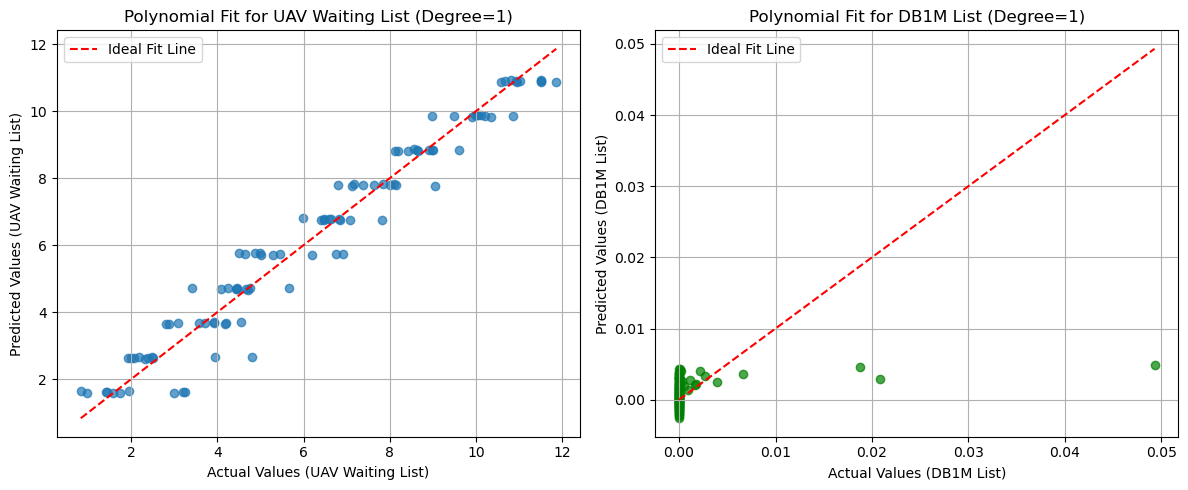


--- Partial Prediction Results ---
UAV Waiting List (Actual vs. Predicted):
  Actual: 10.94, Predicted: 10.86
  Actual: 10.35, Predicted: 9.83
  Actual: 8.42, Predicted: 8.80
  Actual: 7.13, Predicted: 7.77
  Actual: 7.82, Predicted: 6.74

DB1M List (Actual vs. Predicted):
  Actual: 0.00, Predicted: -0.00
  Actual: 0.00, Predicted: -0.00
  Actual: 0.00, Predicted: -0.00
  Actual: 0.00, Predicted: -0.00
  Actual: 0.00, Predicted: -0.00


In [306]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(uavwaitinglist, y_pred_uav, alpha=0.7)
plt.plot([min(uavwaitinglist), max(uavwaitinglist)],
         [min(uavwaitinglist), max(uavwaitinglist)],
         color='red', linestyle='--', label='Ideal Fit Line')
plt.xlabel("Actual Values (UAV Waiting List)")
plt.ylabel("Predicted Values (UAV Waiting List)")
plt.title(f"Polynomial Fit for UAV Waiting List (Degree={degree})")
plt.grid(True)
plt.legend()

# --- Visualize DB1M List Fit Results ---
plt.subplot(1, 2, 2)
plt.scatter(db1mlist, y_pred_db1m, alpha=0.7, color='green')
plt.plot([min(db1mlist), max(db1mlist)],
         [min(db1mlist), max(db1mlist)],
         color='red', linestyle='--', label='Ideal Fit Line') # Changed label here too
plt.xlabel("Actual Values (DB1M List)")
plt.ylabel("Predicted Values (DB1M List)")
plt.title(f"Polynomial Fit for DB1M List (Degree={degree})")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# --- Display Partial Prediction Results ---
print("\n--- Partial Prediction Results ---")
print("UAV Waiting List (Actual vs. Predicted):")
for i in range(5):
    print(f"  Actual: {uavwaitinglist[i]:.2f}, Predicted: {y_pred_uav[i]:.2f}")

print("\nDB1M List (Actual vs. Predicted):")
for i in range(5):
    print(f"  Actual: {db1mlist[i]:.2f}, Predicted: {y_pred_db1m[i]:.2f}")

In [ ]:
meanlist = []
for i in range(100):
    meanlist.append(np.mean(uavwaitinglist[10*i:10*(i+1)]))
meanlist

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# 定义实验参数
uavexp_rates = np.linspace(0.009, 0.0095, 10)  # 不同的 UAV 到达率
arrivalrates = np.linspace(0.01, 0.015, 10)    # 不同的货物到达率
errors = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差
mm1_wlist = []
db1mlist = []
# 实验循环
for i, uavexp_rate in enumerate(uavexp_rates):
    for j, arrivalrate in enumerate(arrivalrates):
        # 计算理论值和模拟值
        mu = uavexp_rate
        lambda_ = arrivalrate
        mm1_w = 1 / (1/mu - 1/lambda_) 
        mm1_wlist.append(mm1_w)
        goodsarrivetime_mean = 0.1  
        goodsexp_mean = 1/arrivalrate*goodsarrivetime_mean        # Average number of goods per batch

        global_goods_num = 0
        global_goods_waitingtime = 0
        env = simpy.Environment()
        station = DBMDistributionStation(env, goodsarrivetime_mean, goodsexp_mean, uavexp_rate)
        
        simulation_duration = 50
        env.run(until=simulation_duration)

        dbm1_w = global_goods_waitingtime / global_goods_num
        db1mlist.append(dbm1_w)
        # 计算误差
        errors[i, j] = np.abs(mm1_w - dbm1_w) / dbm1_w * 100

# 绘制误差热力图
plt.figure(figsize=(10, 8))
plt.imshow(errors, extent=[arrivalrates[0], arrivalrates[-1], uavexp_rates[0], uavexp_rates[-1]], 
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Relative Error (%)')
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('UAV Arrival Rate (uavexp_rate)')
plt.title('Relative Error between M/M/1 and Dᵇ/M/1')
plt.show()
print(errors.mean())

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# 定义实验参数
uavexp_rates = np.linspace(0.009, 0.0095, 10)  # 不同的 UAV 到达率
arrivalrates = np.linspace(0.005, 0.025, 10)    # 不同的货物到达率
errors = np.zeros((len(uavexp_rates), len(arrivalrates)))  # 存储误差
mm1_wlist = []
db1mlist = []
# 实验循环
for i, uavexp_rate in enumerate(uavexp_rates):
    for j, arrivalrate in enumerate(arrivalrates):
        # 计算理论值和模拟值
        mu = arrivalrate*0.95
        lambda_ = arrivalrate
        mm1_w = 1 / (1/mu - 1/lambda_) 
        mm1_wlist.append(mm1_w)
        goodsarrivetime_mean = 0.05  
        goodsexp_mean = 1/arrivalrate*goodsarrivetime_mean        # Average number of goods per batch

        global_goods_num = 0
        global_goods_waitingtime = 0
        env = simpy.Environment()
        station = DBMDistributionStation(env, goodsarrivetime_mean, goodsexp_mean, mu)
        
        simulation_duration = 50
        env.run(until=simulation_duration)

        dbm1_w = global_goods_waitingtime / global_goods_num
        db1mlist.append(dbm1_w)
        # 计算误差
        errors[i, j] = np.abs(mm1_w - dbm1_w) / dbm1_w * 100

# 绘制误差热力图
plt.figure(figsize=(10, 8))
plt.imshow(errors, extent=[arrivalrates[0], arrivalrates[-1], arrivalrates[0]*0.95, arrivalrates[-1]*0.95], 
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Relative Error (%)')
plt.xlabel('Goods Arrival interval (1/λ)')
plt.ylabel('UAV Service time interval (1/μ)')    
plt.show()
print(errors.mean())

In [105]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt

def simulate_dbm1(T, b, mu, num_arrivals=1000):
    """
    Simulate Dᵇ/M/1 queue
    T: inter-arrival time (minutes)
    b: batch size
    mu: service rate (cargos per minute)
    num_arrivals: number of truck arrivals
    """
    # Arrival times (fixed intervals)
    arrival_times = np.arange(0, num_arrivals * T, T)
    
    # Generate cargo arrivals (b cargos per truck)
    cargo_arrivals = []
    for t in arrival_times:
        batch = max(1, int(np.random.exponential(b))) # Ensure at least one good arrives
        for _ in range(batch):
            cargo_arrivals.append(t)
    cargo_arrivals = sorted(cargo_arrivals)
    
    # Simulate service times (exponential)
    service_times = expon.rvs(scale=1/mu, size=len(cargo_arrivals))
    
    # Track system times
    queue = []
    departure_times = []
    current_time = 0
    server_busy_until = 0
    
    for arrival in cargo_arrivals:
        # Add to queue
        queue.append(arrival)
        
        # Process queue
        while queue and server_busy_until <= current_time:
            # Start service
            server_busy_until = max(current_time, queue[0]) + service_times[len(departure_times)]
            departure_times.append(server_busy_until)
            queue.pop(0)
            current_time = server_busy_until
    
    # System times
    system_times = np.array(departure_times) - np.array(cargo_arrivals)
    return np.mean(system_times)

def mm1_system_time(lambda_, mu):
    """
    M/M/1 system time
    lambda_: arrival rate (cargos per minute)
    mu: service rate (cargos per minute)
    """
    return 1 / (mu - lambda_)

# Parameters
T = 10  # inter-arrival time (minutes)
b = 5   # batch size
mu = 0.8  # service rate (cargos per minute)
lambda_ = b / T  # arrival rate (cargos per minute)


dbm1_w = simulate_dbm1(T, b, mu, num_arrivals=10000)
print(f"Dᵇ/M/1 system time: {dbm1_w:.2f} minutes")

# Calculate M/M/1
mm1_w = mm1_system_time(lambda_, mu)
print(f"M/M/1 system time: {mm1_w:.2f} minutes")

# Error
error = (np.abs(mm1_w - dbm1_w)) / dbm1_w * 100
print(f"Relative error: {error:.2f}%")

Dᵇ/M/1 system time: 10.20 minutes
M/M/1 system time: 3.33 minutes
Relative error: 67.32%


In [103]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt

def simulate_dbm1(T, b, mu, num_arrivals=1000):
    """
    Simulate Dᵇ/M/1 queue
    T: inter-arrival time (minutes)
    b: batch size
    mu: service rate (cargos per minute)
    num_arrivals: number of truck arrivals
    """
    # Arrival times (fixed intervals)
    arrival_times = np.arange(0, num_arrivals * T, T)
    
    # Generate cargo arrivals (b cargos per truck)
    cargo_arrivals = []
    for t in arrival_times:
        batch = max(1, int(np.random.exponential(b))) # Ensure at least one good arrives
        for _ in range(b):
            cargo_arrivals.append(t)
    cargo_arrivals = sorted(cargo_arrivals)
    
    # Simulate service times (exponential)
    service_times = expon.rvs(scale=1/mu, size=len(cargo_arrivals))
    
    # Track system times
    queue = []
    departure_times = []
    current_time = 0
    server_busy_until = 0
    
    for arrival in cargo_arrivals:
        # Add to queue
        queue.append(arrival)
        
        # Process queue
        while queue and server_busy_until <= current_time:
            # Start service
            server_busy_until = max(current_time, queue[0]) + service_times[len(departure_times)]
            departure_times.append(server_busy_until)
            queue.pop(0)
            current_time = server_busy_until
    
    # System times
    system_times = np.array(departure_times) - np.array(cargo_arrivals)
    return np.mean(system_times)

def mm1_system_time(lambda_, mu):
    """
    M/M/1 system time
    lambda_: arrival rate (cargos per minute)
    mu: service rate (cargos per minute)
    """
    return 1 / (mu - lambda_)

# Parameters
T = 10  # inter-arrival time (minutes)
b = 5   # batch size
mu = 0.6  # service rate (cargos per minute)
lambda_ = b / T  # arrival rate (cargos per minute)


dbm1_w = simulate_dbm1(T, b, mu, num_arrivals=10000)
print(f"Dᵇ/M/1 system time: {dbm1_w:.2f} minutes")

# Calculate M/M/1
mm1_w = mm1_system_time(lambda_, mu)
print(f"M/M/1 system time: {mm1_w:.2f} minutes")

# Error
error = (np.abs(mm1_w - dbm1_w)) / dbm1_w * 100
print(f"Relative error: {error:.2f}%")

Dᵇ/M/1 system time: 7.91 minutes
M/M/1 system time: 10.00 minutes
Relative error: 26.43%


In [ ]:
import simpy
import numpy as np

global_uav_num = 0
global_goods_num = 0
global_uav_waitingtime = 0
global_goods_waitingtime = 0

class UAV:
    def __init__(self, env, name,starttime):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class Goods:
    def __init__(self, env, name,starttime=0):
        self.env = env
        self.waitingtime = 0
        self.starttime = starttime
        self.ifserve = False
        self.name = name

    def enter_queue(self, env):
        self.starttime = env.now

    def start_service(self, env):
        self.ifserve = True

    def end_service(self, env):
        if self.ifserve:
            self.waitingtime = env.now - self.starttime
            self.ifserve = False

class DistributionStation:
    def __init__(self, env, goodsarrivetime, goodsexp, uavexp, service_time_mean):
        self.env = env
        self.goodsarrivetime = goodsarrivetime
        self.goodsexp = goodsexp
        self.uavexp = uavexp
        self.service_time_mean = service_time_mean
        self.uavqueue = simpy.Store(env) # Changed to simpy.Store
        self.goodsqueue = simpy.Store(env)
        self.uav_list = [] # To track individual UAVs if needed

        self.goods_count = 0
        env.process(self.goods_arrival_process())
        env.process(self.uav_arrival_process())
        env.process(self.serving_process())

    def goods_arrival_process(self):
        while True:
            yield self.env.timeout(self.goodsarrivetime)
            num_goods = max(1, int(np.random.exponential(scale=self.goodsexp))) # Ensure at least one good arrives
            print(f"Goods batch of size {num_goods} arrives at {self.env.now}")
            for i in range(num_goods):
                goods1 = Goods(self.env, f"goods {self.goods_count}",starttime=self.env.now)
                goods1.enter_queue(self.env)
                yield self.goodsqueue.put(goods1) # Yield when putting into the store
                self.goods_count += 1
                print(f"Goods {goods1.name} arrive at {self.env.now}")

    def uav_arrival_process(self):
        uav_id = 0
        while True:
            yield self.env.timeout(np.random.exponential(scale=self.uavexp))
            uav1 = UAV(self.env, f"uav {uav_id}",starttime=self.env.now)
            self.uav_list.append(uav1)
            yield self.uavqueue.put(uav1) # Yield when putting into the store
            print(f"UAV {uav1.name} arrives at {self.env.now}")
            uav_id += 1

    def serving_process(self):
        global global_uav_num
        global global_goods_num
        global global_uav_waitingtime
        global global_goods_waitingtime

        while True:
            # Wait for a good and a UAV to be available
            goods_to_serve = yield self.goodsqueue.get()
            uav_available = yield self.uavqueue.get() # Get a UAV from the store

            # Start service
            goods_to_serve.start_service(self.env)
            uav_available.start_service(self.env)

            goods_to_serve.waitingtime = self.env.now - goods_to_serve.starttime
            uav_available.waitingtime = self.env.now - uav_available.starttime

            global_goods_waitingtime += goods_to_serve.waitingtime
            global_uav_waitingtime += uav_available.waitingtime

            print(f"UAV {uav_available.name} starts serving {goods_to_serve.name} at {self.env.now}")
            # yield self.env.timeout(np.random.exponential(scale=self.service_time_mean)) # Service time

            # End service
            goods_to_serve.end_service(self.env)
            uav_available.end_service(self.env)

            global_goods_num += 1
            global_uav_num += 1
            print(f"UAV {uav_available.name} finishes serving {goods_to_serve.name} at {self.env.now}, Goods waiting time: {goods_to_serve.waitingtime:.2f}, UAV waiting time: {uav_available.waitingtime:.2f}")

env = simpy.Environment()
goodsarrivetime_mean = 5  # Average time between batch arrivals
goodsexp_mean = 50        # Average number of goods per batch
uavexp_mean = 1/20          # Average time between UAV arrivals (inverse of arrival rate)
service_time_mean = 2     # Average service time per good

station = DistributionStation(env, goodsarrivetime_mean, goodsexp_mean, uavexp_mean, service_time_mean)

simulation_duration = 200
env.run(until=simulation_duration)

if global_goods_num > 0:
    print(f"Average Goods Waiting Time (Served): {global_goods_waitingtime / global_goods_num:.2f}")
else:
    print("No goods were served.")

if global_uav_num > 0:
    print(f"Average UAV Waiting Time (Served): {global_uav_waitingtime / global_uav_num:.2f}")
else:
    print("No UAVs performed service.")

# Calculate waiting time for goods remaining in the queue
remaining_goods_wait_time = 0
remaining_goods = list(station.goodsqueue.items)
num_remaining_goods = len(remaining_goods)
for good in remaining_goods:
    remaining_goods_wait_time += env.now - good.starttime

if num_remaining_goods > 0:
    print(f"Average Goods Waiting Time (In Queue at End): {remaining_goods_wait_time / num_remaining_goods:.2f}")
else:
    print("No goods remaining in the queue.")

# Calculate waiting time for UAVs remaining in the queue
remaining_uav_wait_time = 0
remaining_uavs = list(station.uavqueue.items)
num_remaining_uavs = len(remaining_uavs)
for uav_obj in remaining_uavs:
    remaining_uav_wait_time += env.now - uav_obj.starttime

if num_remaining_uavs > 0:
    print(f"Average UAV Waiting Time (In Queue at End): {remaining_uav_wait_time / num_remaining_uavs:.2f}")
else:
    print("No UAVs remaining in the queue.")

In [4]:
service_num = 0
global_var = 0
class ChargingStation:
    def __init__(self, env, station_id,latitude, longitude,battery_num,service_time,charge_time,min_num):
        self.env = env
        self.station_id = station_id
        self.battery_num = battery_num
        self.latitude = latitude
        self.longitude = longitude
        self.service_time = service_time
        self.charge_time = charge_time
        self.min_num = min_num
        self.busy = False
        self.queue = []
        


    def charge(self):
        yield self.env.timeout(np.random.exponential(scale=self.charge_time))
        self.battery_num+=2
        print(f" Station {self.station_id} Charge at {self.env.now} have battery {self.battery_num} ")


        
    def serve(self,uav):
        global global_var
        print(f"serve function {uav.uav_id},station{self.station_id}, queue length :{len(self.queue)}")
        uav.ifcharge = True
        print(f"serve function {uav.uav_id},charge status :{uav.ifcharge}")
        if len(self.queue)>0 and self.battery_num>self.min_num:
            self.busy = True
            yield self.env.timeout(np.random.exponential(scale=self.service_time))
            if len(self.queue)>0: 
                uav1 = self.queue[0]
                self.queue.pop(0).ifcharge = False
                self.battery_num-=2
                print(f"UAV {uav1.uav_id} at time {self.env.now} at {self.station_id} charge battery left {self.battery_num}")
                self.env.process(self.charge())
                print(f"after serving UAV {uav1.uav_id},charge status :{uav1.ifcharge}")
                print("-------------------")
            global_var += 1
            self.busy = False
        if len(self.queue)>0 and self.battery_num>self.min_num:
            self.env.process(self.serve(self.queue[0]))
            


In [ ]:
class Truck:
    def __init__(self, env, truck_id,latitude, longitude,speed,order=0,iffree = True,dist_id=0):
        self.env = env
        self.truck_id = truck_id
        self.latitude = latitude
        self.longitude = longitude
        self.busy = False
        self.speed = speed
        self.order = order
        self.iffree  =iffree
        self.dist_id = dist_id
    
    
    def transport(self):
        self.busy = True
        transport_time = 2*calculate_time(s_lat, s_lon, self.latitude, self.longitude)/self.speed  
        yield self.env.timeout(transport_time)
        self.busy = False
        print(f" Truck {self.truck_id} arrive at {self.latitude},{self.longitude} at {self.env.now}")
        
        

In [ ]:
class Distribution_center:
    def __init__(self, env, station_id,latitude, longitude,battery_num,service_time,charge_time,min_num):
        self.env = env
        self.station_id = station_id
        self.battery_num = battery_num
        self.latitude = latitude
        self.longitude = longitude
        self.truck_num = 1
        self.trucklist = [Truck(env,i+station_id,latitude,longitude,32) for i in range(self.truck_num)]
        self.charge_time = char
        self.uavqueue = []
    
    
    def charge(self):
        yield self.env.timeout(np.random.exponential(scale=self.charge_time))
        self.battery_num+=2
        print(f" Station {self.station_id} Charge at {self.env.now} have battery {self.battery_num} ")


        
    def serve(self,uav):
        global global_var
        print(f"serve function {uav.uav_id},station{self.station_id}, queue length :{len(self.queue)}")
        uav.ifcharge = True
        print(f"serve function {uav.uav_id},charge status :{uav.ifcharge}")
        if len(self.queue)>0 and self.battery_num>self.min_num:
            self.busy = True
            yield self.env.timeout(np.random.exponential(scale=self.service_time))
            if len(self.queue)>0: 
                uav1 = self.queue[0]
                self.queue.pop(0).ifcharge = False
                self.battery_num-=2
                print(f"UAV {uav1.uav_id} at time {self.env.now} at {self.station_id} charge battery left {self.battery_num}")
                self.env.process(self.charge())
                print(f"after serving UAV {uav1.uav_id},charge status :{uav1.ifcharge}")
                print("-------------------")
            global_var += 1
            self.busy = False
        if len(self.queue)>0 and self.battery_num>self.min_num:
            self.env.process(self.serve(self.queue[0]))
            
            

In [1]:
def calculate_distance(lat1, lon1, lat2, lon2):
    earth_radius = 6371.0  # 地球半径（以公里为单位）

    # 将经纬度转换为弧度
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine公式
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius * c
    return distance

In [ ]:
class Order:
    def __init__(self, env, demand_point_id,uav_id,order_id,servicetime,beigin_time,end_time,direc,distance,if_finished = False):
        self.env = env
        self.demand_point_id = demand_point_id
        self.uav_id = uav_id
        self.order_id = order_id
        self.begin_time = beigin_time
        self.end_time = end_time
        self.servicetime = servicetime
        self.direc = direc
        self.distance = distance
        self.if_finished = if_finished

In [ ]:
finished_order = []
chargelist  = []
finished_num = 0
s_lat = 30.2741
s_lon = 120.1476
class Service_point:
    def __init__(self, env, demand_point_id,arrival_time,latitude, longitude,serviceid,servicetime):
        self.env = env
        self.demand_point_id = demand_point_id
        self.arrival_time = arrival_time
        self.latitude = latitude
        self.longitude = longitude
        self.serviceid = serviceid
        self.servicetime = servicetime


        
        
        

class UAV:
    def __init__(self, env, uav_id,latitude, longitude,speed,order=0,iffree = True,ifcharge = False):
        self.env = env
        self.uav_id = uav_id
        self.latitude = latitude
        self.longitude = longitude
        self.busy = False
        self.speed = speed
        self.order = order
        self.iffree  =iffree
        self.ifcharge  =ifcharge
        self.target = 0
        
        
        
    def fulfill_demand(self,order):
        global finished_order
        global finished_num
        global chargelist
        for i in range(location.shape[0]):
            chargelist.append(ChargingStation(self.env,i,location.iloc[i,2],location.iloc[i,3],10,0.1,5,2))
        while True:
            self.order = order
            dist = self.order.distance
            direc = self.order.direc
            self.iffree = False
            while self.target!=len(direc):
                if self.ifcharge==False:
                    yield self.env.timeout(dist[self.target] / self.speed)
                    print(f"UAV{self.uav_id}  arrive at point {direc[self.target]} at time {self.env.now}, target:{self.target}")
                    chargelist[direc[self.target]].queue.append(self)
                    #self.ifcharge=True
                    self.env.process(chargelist[direc[self.target]].serve(self))
                    self.target+=1
            #print(f"Demand of{self.order.begin_time} / {self.order.order_id} finished at time {self.env.now}")
            if self.target==len(direc):
                finished_order.append(order)
                finished_num+=1
                break

In [41]:
total_orders_generated=0
total_order = []
class Demand_point:
    total_orders_generated = 0  # 类变量用于跟踪所有需求点的需求数量

    def __init__(self, env, demand_point_id, latitude, longitude, uavnum, demand_time):
        self.env = env
        self.demand_point_id = demand_point_id
        self.latitude = latitude
        self.longitude = longitude
        self.uavnum = uavnum
        self.uavqueue = []
        self.demand_time = demand_time
        self.orders_generated = 0

    def generate_demand(self):
        global total_orders_generated
        global total_order
        while True:
            order_id = random.randint(1, 10000)
            self.orders_generated += 1  # 增加订单数量计数器
            total_orders_generated+=1
            direc = [4,5,0]
            distance = [500,530,430]
            neworder = Order(self.env, self.demand_point_id,0,order_id,0,self.env.now,0,direc,distance)
            total_order.append(neworder)
            if(self.uavnum>0):
                uav = self.uavqueue.pop(0)
                self.uavnum-=1
                self.env.process(uav.fulfill_demand(neworder))
            #print(f"Demand generated at point {self.demand_point_id} at time {self.env.now}")
            yield self.env.timeout(np.random.exponential(scale=self.demand_time))

In [ ]:
import simpy
import numpy as np
import random
import pandas as pd

connect = pd.read_excel(r'data/connect2.xlsx')
dist1 = pd.read_excel(r'data/dist2.xlsx')
location = pd.read_excel(r'data/location2.xlsx')
service_point_number = 249

service_num = 0
global_var = 0


class ChargingStation:
    def __init__(self, env, station_id, latitude, longitude, battery_num, service_time, charge_time, min_num):
        self.env = env
        self.station_id = station_id
        self.battery_num = battery_num
        self.latitude = latitude
        self.longitude = longitude
        self.service_time = service_time
        self.charge_time = charge_time
        self.min_num = min_num
        self.busy = False
        self.queue = []
        self.service_num = 400

    def charge(self):
        yield self.env.timeout(np.random.exponential(scale=self.charge_time))
        self.battery_num += 2
        print(f" Station {self.station_id} Charge at {self.env.now} have battery {self.battery_num} ")
        

    def servetime(self):
        yield self.env.timeout(0.1)

    def servetime2(self):
        if len(self.queue) < self.service_num:
            yield self.env.timeout(0.15)
        else:
            while len(self.queue) >= self.service_num:
                yield self.env.timeout(0.5)

    def serve(self, uav):
        global global_var
        print(f"serve function {uav.uav_id},station{self.station_id}, queue length :{len(self.queue)}")
        uav.ifcharge = True
        continue_serve = True
        while self.battery_num < self.min_num:
            yield self.env.process(self.charge())
        while continue_serve and uav.ifcharge != False:
            if len(self.queue) > 0 and self.battery_num > self.min_num:
                self.busy = True
                print(f"Try to service serve function {uav.uav_id},time {self.env.now}")
                if len(self.queue) > 0 and self.battery_num > self.min_num:
                    if self.station_id == service_point_number:
                        yield self.env.process(self.servetime2())
                    else:
                        yield self.env.process(self.servetime())
                    uav1 = self.queue[0]
                    self.queue.pop(0).ifcharge = False
                    print(f"After Go service serve function {uav1.uav_id},time {self.env.now}")
                    self.battery_num -= 2
                    print(
                        f"UAV {uav1.uav_id} at time {self.env.now} at {self.station_id} charge battery left {self.battery_num}")
                    self.env.process(self.charge())
                    global_var += 1
                    self.busy = False
                    if uav1.uav_id == uav.uav_id:
                        continue_serve = False  # 设置标志为 False，退出循环
                        #yield self.env.timeout(0)
                    else:
                        if len(self.queue) > 0 and self.battery_num > self.min_num:
                            self.env.process(self.serve(self.queue[0]))
                        else:
                            pass


class Order:
    def __init__(self, env, demand_point_id, uav_id, order_id, servicetime, beigin_time, end_time, direc, distance,
                 if_finished=False):
        self.env = env
        self.demand_point_id = demand_point_id
        self.uav_id = uav_id
        self.order_id = order_id
        self.begin_time = beigin_time
        self.end_time = end_time
        self.servicetime = servicetime
        self.direc = direc
        self.distance = distance
        self.if_finished = if_finished


finished_order = []
service_timelist = []
chargelist = []
finished_num = 0
uav_cost = 0


class Service_point:
    def __init__(self, env, demand_point_id, arrival_time, latitude, longitude, serviceid, servicetime):
        self.env = env
        self.demand_point_id = demand_point_id
        self.arrival_time = arrival_time
        self.latitude = latitude
        self.longitude = longitude
        self.serviceid = serviceid
        self.servicetime = servicetime


class UAV:
    def __init__(self, env, uav_id, latitude, longitude, speed, order=0, iffree=True, ifcharge=False):
        self.env = env
        self.uav_id = uav_id
        self.latitude = latitude
        self.longitude = longitude
        self.busy = False
        self.speed = speed
        self.order = order
        self.iffree = iffree
        self.ifcharge = ifcharge
        self.target = 0
        self.start_time = 0
        self.end_time = 0

    def fulfill_demand(self, order):
        global finished_order
        global finished_num
        global chargelist
        global service_timelist
        for i in range(location.shape[0]):
            chargelist.append(ChargingStation(self.env, i, location.iloc[i, 2], location.iloc[i, 3], 5, 2, 2, 2))
        while True:
            self.order = order
            dist = self.order.distance
            direc = self.order.direc
            self.start_time = self.env.now
            self.iffree = False
            while self.target != len(direc):
                if self.ifcharge == False:
                    yield self.env.timeout(dist[self.target] / self.speed)
                    print(
                        f"UAV{self.uav_id}  arrive at point {direc[self.target]} at time {self.env.now}, target:{self.target}")
                    chargelist[direc[self.target]].queue.append(self)
                    # self.ifcharge=True
                    yield self.env.process(chargelist[direc[self.target]].serve(self))
                    #yield self.env.timeout(0)
                    self.target += 1
            # print(f"Demand of{self.order.begin_time} / {self.order.order_id} finished at time {self.env.now}")
            if self.target == len(direc):
                finished_order.append(order)
                finished_num += 1
                self.iffree = True
                self.end_time = self.env.now
                service_timelist.append(self.end_time - self.start_time)
                break


total_orders_generated = 0
total_order = []


class Demand_point:
    total_orders_generated = 0  # 类变量用于跟踪所有需求点的需求数量

    def __init__(self, env, demand_point_id, latitude, longitude, uavnum, demand_time):
        self.env = env
        self.demand_point_id = demand_point_id
        self.latitude = latitude
        self.longitude = longitude
        self.uavnum = uavnum
        self.uavqueue = []
        self.demand_time = demand_time
        self.orders_generated = 0

    def waitnewuav(self):
        while self.uavnum <= 0:
            print("Wait for new UAV")
            yield self.env.timeout(5)

    def generate_demand(self):
        global total_orders_generated
        global total_order
        while True:
            order_id = random.randint(1, 10000)
            self.orders_generated += 1  # 增加订单数量计数器
            total_orders_generated += 1
            direc = [18, 69, 180, 210, 249, 217, 72, 66, 0]
            distance = [dist1.iloc[0, 18], dist1.iloc[18, 69], dist1.iloc[69, 180], dist1.iloc[180, 210],
                        dist1.iloc[210, 249], dist1.iloc[249, 217], dist1.iloc[217, 72], dist1.iloc[72, 66],
                        dist1.iloc[66, 0]]
            neworder = Order(self.env, self.demand_point_id, 0, order_id, 0, self.env.now, 0, direc, distance)
            total_order.append(neworder)
            if self.uavnum > 0:
                uav = self.uavqueue.pop(0)
                self.uavnum -= 1
                self.env.process(uav.fulfill_demand(neworder))
                yield self.env.timeout(0)
                self.uavqueue.append(uav)
                neworder.if_finished = True
                neworder.end_time = self.env.now
            else:
                self.env.process(self.waitnewuav())
            # print(f"Demand generated at point {self.demand_point_id} at time {self.env.now}")
            yield self.env.timeout(np.random.exponential(scale=self.demand_time))


def run_simulation(num_demand_points, latitude, longitude, uavnum, demand_time, simulation_time):
    # 创建仿真环境
    env = simpy.Environment()
    # 创建需求点并添加到仿真环境中
    demand_points = []
    for i in range(num_demand_points):
        demand_point = Demand_point(env, demand_point_id=i, latitude=latitude, longitude=longitude, uavnum=uavnum,
                                    demand_time=demand_time)

        used_ids = set()  # 存储已使用的uav_id
        for i in range(demand_point.uavnum):
            uavid = random.randint(1, 50000)
            while uavid in used_ids:  # 检查uavid是否已存在于集合中
                uavid = random.randint(1, 50000)
            used_ids.add(uavid)  # 将uavid添加到集合中
            demand_point.uavqueue.append(
                UAV(env, uav_id=uavid, latitude=demand_point.latitude, longitude=demand_point.longitude,
                    speed=random.randint(30, 50)))

        demand_points.append(demand_point)
        env.process(demand_point.generate_demand())
    # 运行仿真直到指定时间
    env.run(until=simulation_time)
    return demand_points


# 调用函数来运行仿真
num_demand_points = 4
latitude = 37.7749
longitude = -122.4194
uavnum = 300
demand_time = 0.1
simulation_time = 24

demand_points = run_simulation(num_demand_points, latitude, longitude, uavnum, demand_time, simulation_time)

In [6]:
if 0.1%0.05==0:
    print("1")

1


In [31]:
connect = pd.read_excel(r'data/connect2.xlsx')
dist1 = pd.read_excel(r'data/dist2.xlsx')
location = pd.read_excel(r'data/location2.xlsx')
location

,Unnamed: 0,index,lng,lat
0,0,0,113.962367,22.590502
1,1,1,113.552982,22.357572
2,2,2,113.080259,22.600326
3,3,3,113.386631,23.054778
4,4,4,114.073908,22.537692
...,...,...,...,...
245,245,254,113.394703,22.083607
246,246,255,113.345705,22.129363
247,247,256,113.346690,22.139801
248,248,257,113.372497,22.063397


In [ ]:
import simpy
import numpy as np
import random
import pandas as pd

connect = pd.read_excel(r'data/connect2.xlsx')
dist1 = pd.read_excel(r'data/dist2.xlsx')
location = pd.read_excel(r'data/location2.xlsx')
service_point_number = 249

service_num = 0
global_var = 0


class ChargingStation:
    def __init__(self, env, station_id, latitude, longitude, battery_num, service_time, charge_time, min_num):
        self.env = env
        self.station_id = station_id
        self.battery_num = battery_num
        self.latitude = latitude
        self.longitude = longitude
        self.service_time = service_time
        self.charge_time = charge_time
        self.min_num = min_num
        self.busy = False
        self.queue = []
        self.service_num = 400

    def charge(self):
        yield self.env.timeout(np.random.exponential(scale=self.charge_time))
        self.battery_num += 2
        print(f" Station {self.station_id} Charge at {self.env.now} have battery {self.battery_num} ")
        

    def servetime(self):
        yield self.env.timeout(np.random.exponential(scale=self.service_time))

    def servetime2(self):
        if len(self.queue) < self.service_num:
            yield self.env.timeout(np.random.exponential(scale=self.service_time)+np.random.exponential(scale=0.017))
        else:
            while len(self.queue) >= self.service_num:
                yield self.env.timeout(0.001)
                
    def servetime2(self):
        yield self.env.timeout(np.random.exponential(scale=self.service_time)+np.random.exponential(scale=0.017))

    def serve(self, uav):
        global global_var
        print(f"serve function {uav.uav_id},station{self.station_id}, queue length :{len(self.queue)}")
        uav.ifcharge = True
        continue_serve = True
        while self.queue[0].uav_id != uav.uav_id:
            yield self.env.timeout(0.001)
        while self.battery_num < self.min_num:
            yield self.env.process(self.charge())
        while continue_serve and uav.ifcharge != False:
            if len(self.queue) > 0 and self.battery_num >= self.min_num and self.queue[0].uav_id == uav.uav_id:
                self.busy = True
                print(f"Try to service serve function {uav.uav_id},time {self.env.now}")
                for i in uavlist:
                    i.service_time = self.env.now - i.start_time
                queuelist[self.station_id].append(len(self.queue))
                if len(self.queue) > 0 and self.battery_num >= self.min_num:
                    if self.queue[0].uav_id==uav.uav_id:
                        if self.station_id == service_point_number:
                            yield self.env.process(self.servetime2())
                        else:
                            yield self.env.process(self.servetime())
                    else:
                        yield self.env.process(self.servetime())
                    uav1 = self.queue[0]
                    self.queue.pop(0).ifcharge = False
                    uav1.ifcharge = False
                    print(f"After Go service serve function {uav1.uav_id},time {self.env.now}")
                    self.battery_num -= 2
                    print(
                        f"UAV {uav1.uav_id} at time {self.env.now} at {self.station_id} charge battery left {self.battery_num}")
                    self.env.process(self.charge())
                    global_var += 1
                    self.busy = False
                    if uav1.uav_id == uav.uav_id:
                        print("now")
                        continue_serve = False  # 设置标志为 False，退出循环
                        break
                    else:
                        if len(self.queue) > 0 and self.battery_num > self.min_num:
                            print("continue")
                            self.env.process(self.serve(self.queue[0]))
                        else:
                            pass
                if self.battery_num < self.min_num:
                    yield self.env.process(self.charge())


class Order:
    def __init__(self, env, demand_point_id, uav_id, order_id, servicetime, beigin_time, end_time, direc, distance,
                 if_finished=False):
        self.env = env
        self.demand_point_id = demand_point_id
        self.uav_id = uav_id
        self.order_id = order_id
        self.begin_time = beigin_time
        self.end_time = end_time
        self.servicetime = servicetime
        self.direc = direc
        self.distance = distance
        self.if_finished = if_finished


finished_order = []
service_timelist = []
chargelist = []
finished_num = 0
uav_cost = 0
latitudelist = [[]]



class Service_point:
    def __init__(self, env, demand_point_id, arrival_time, latitude, longitude, serviceid, servicetime):
        self.env = env
        self.demand_point_id = demand_point_id
        self.arrival_time = arrival_time
        self.latitude = latitude
        self.longitude = longitude
        self.serviceid = serviceid
        self.servicetime = servicetime


class UAV:
    def __init__(self, env, uav_id, latitude, longitude, speed, order=0, iffree=True, ifcharge=False):
        self.env = env
        self.uav_id = uav_id
        self.latitude = latitude
        self.longitude = longitude
        self.busy = False
        self.speed = speed
        self.order = order
        self.iffree = iffree
        self.ifcharge = ifcharge
        self.target = 0
        self.start_time = 0
        self.end_time = 0
        self.service_time = 0

    def fulfill_demand(self, order):
        global finished_order
        global finished_num
        global chargelist
        global service_timelist
        for i in range(location.shape[0]):
            chargelist.append(ChargingStation(self.env, i, location.iloc[i, 2], location.iloc[i, 3], 5000, 0.0027, 2, 2))
        while True:
            self.order = order
            dist = self.order.distance
            direc = self.order.direc
            self.start_time = self.env.now
            self.service_time = 0
            self.iffree = False
            while self.target != len(direc):
                if self.ifcharge == False:
                    if self.target < len(direc):
                        yield self.env.timeout(dist[self.target] / self.speed)
                        print(
                            f"UAV{self.uav_id}  arrive at point {direc[self.target]} at time {self.env.now}, target:{self.target}")
                        chargelist[direc[self.target]].queue.append(self)
                        # self.ifcharge=True
                        yield self.env.process(chargelist[direc[self.target]].serve(self))
                        yield self.env.timeout(0)
                        self.target += 1
            # print(f"Demand of{self.order.begin_time} / {self.order.order_id} finished at time {self.env.now}")
            if self.target == len(direc):
                finished_order.append(order)
                finished_num += 1
                for uav1 in uavlist:
                    if uav1.target == len(uav1.order.direc):
                        finisheduavlist.append(uav1)
                        uavlist.remove(uav1)
                        uav1.order.if_finished = True
                        uav1.order.end_time = self.env.now
                        demand_points[uav1.order.direc[-1]].uavqueue.append(uav1)
                        demand_points[uav1.order.direc[-1]].uavnum+=1
                self.iffree = True
                self.end_time = self.env.now
                service_timelist.append(self.end_time - self.start_time)
                break



total_orders_generated = 0
total_order = []
unassigned_order = []
assigned_order = []
uavlist = []
finisheduavlist = []
queuelist = []
for i in range(location.shape[0]):
    queuelist.append([])


class Demand_point:
    total_orders_generated = 0  # 类变量用于跟踪所有需求点的需求数量

    def __init__(self, env, demand_point_id, latitude, longitude, uavnum, demand_time):
        self.env = env
        self.demand_point_id = demand_point_id
        self.latitude = latitude
        self.longitude = longitude
        self.uavnum = uavnum
        self.uavqueue = []
        self.demand_time = demand_time
        self.orders_generated = 0

    def waitnewuav(self):
        while self.uavnum <= 0:
            print("Wait for new UAV")
            for uav1 in uavlist:
                if uav1.target == len(uav1.order.direc):
                    finisheduavlist.append(uav1)
                    uavlist.remove(uav1)
                    uav1.order.if_finished = True
                    uav1.order.end_time = self.env.now
                    if uav1.order.direc[-1]==self.demand_point_id:
                        self.uavqueue.append(uav1)
                        self.uavnum+=1
            yield self.env.timeout(0.1)

    def generate_demand(self):
        global total_orders_generated
        global total_order
        global unassigned_order
        global assigned_order
        global uavlist
        global queuelist
        while True:
            order_id = random.randint(1, 10000)
            self.orders_generated += 1  # 增加订单数量计数器
            total_orders_generated += 1
            #direc = [18, 69, 180, 210, 249, 217, 72, 66, 0]
            direc = [[15,69,177,175,217,249,213,176,181,72,22,18,10,0],[209,230,249,211,1],[200,249,215,204,202,197,199,201,192,2],[154,249,97,3]]
            distance = []
            for i in range(len(direc)):
                distance1 = []
                for j in range(len(direc[i])):
                    if j==0:
                        distance1.append(dist1.iloc[i,direc[i][j]])
                    else:
                        distance1.append(dist1.iloc[direc[i][j-1],direc[i][j]])
                distance.append(distance1) 
            neworder = Order(self.env, self.demand_point_id, 0, order_id, 0, self.env.now, 0, direc[self.demand_point_id], distance[self.demand_point_id])
            total_order.append(neworder)
            unassigned_order.append(neworder)
            if self.uavnum > 0 and len(unassigned_order)<2:
                uav = self.uavqueue.pop(0)
                uavlist.append(uav)
                self.uavnum -= 1
                unassigned_order.pop(0)
                assigned_order.append(neworder)
                self.env.process(uav.fulfill_demand(neworder))
                yield self.env.timeout(0)
            if self.uavnum > 0 and len(unassigned_order)>=2:
                uav = self.uavqueue.pop(0)
                uavlist.append(uav)
                self.uavnum -= 1
                neworder1 = unassigned_order.pop(0)
                assigned_order.append(neworder1)
                self.env.process(uav.fulfill_demand(neworder1))
                yield self.env.timeout(0)
                
            # if self.uavnum<=0:
            #     for uav1 in uavlist:
            #         if uav1.target == len(uav1.order.direc):
            #             finisheduavlist.append(uav1)
            #             uavlist.remove(uav1)
            #             uav1.order.if_finished = True
            #             uav1.order.end_time = self.env.now
            #             if uav1.order.direc[-1]==self.demand_point_id:
            #                 self.uavqueue.append(uav1)
            #                 self.uavnum+=1
            #     pass
            # else:
            #     self.env.process(self.waitnewuav())
            # print(f"Demand generated at point {self.demand_point_id} at time {self.env.now}")
            yield self.env.timeout(np.random.exponential(scale=self.demand_time))


def run_simulation(num_demand_points, uavnum, demand_time, simulation_time):
    # 创建仿真环境
    env = simpy.Environment()
    # 创建需求点并添加到仿真环境中
    demand_points = []
    for i in range(num_demand_points):
        # demand_point = Demand_point(env, demand_point_id=i, latitude=latitude, longitude=longitude, uavnum=uavnum,
        #                             demand_time=demand_time)
        demand_point = Demand_point(env, demand_point_id=i, latitude=location.iloc[i,2], longitude=location.iloc[i,3], uavnum=uavnum,
                                    demand_time=demand_time)
        used_ids = set()  # 存储已使用的uav_id
        for i in range(demand_point.uavnum):
            uavid = random.randint(1, 50000000)
            while uavid in used_ids:  # 检查uavid是否已存在于集合中
                uavid = random.randint(1, 5000000)
            used_ids.add(uavid)  # 将uavid添加到集合中
            demand_point.uavqueue.append(
                UAV(env, uav_id=uavid, latitude=demand_point.latitude, longitude=demand_point.longitude,
                    speed=random.randint(30, 40)))
        demand_points.append(demand_point)
        env.process(demand_point.generate_demand())
    # 运行仿真直到指定时间
    env.run(until=simulation_time)
    return demand_points


# 调用函数来运行仿真
num_demand_points = 4
uavnum = 6000
demand_time = 0.004
simulation_time = 5
demand_points = run_simulation(num_demand_points,  uavnum, demand_time, simulation_time)

In [130]:
indexlist = []
averagelist = []
for i in range(len(queuelist)):
    if len(queuelist[i])!=0:
        indexlist.append(i)
        averagelist.append(sum(queuelist[i])/len(queuelist[i]))

In [131]:
import pandas as pd
aq = pd.DataFrame()
aq['location'] = indexlist
aq['queuelength'] = averagelist
aq

,location,queuelength
0,1,1.000000
1,2,1.000000
2,3,1.000000
3,15,3.252025
4,69,3.557034
5,97,1.000000
6,154,2.886861
7,175,3.445061
8,177,2.998921
9,192,1.014286


In [117]:
import pandas as pd
aq = pd.DataFrame()
aq['location'] = indexlist
aq['queuelength'] = averagelist
aq.to_excel(r'queuelenth1.xlsx')